# Exploratory Data Analysis and Feature Engineering Workshop

#### Created by:

- Vladimir Rybakov, Head of Data Science at [Wave Access](https://www.wave-access.com/)
- Pieter Buteneers ([@PieterButeneers](https://twitter.com/pieterbuteneers)), Director of Engineering in ML & AI at [sinch.com](https://www.sinch.com/) 

In this workshop you will learn about different methods of data preprocessing and analysis.

Agenda:

1. Cleaning and transforming data, preparing it for further processing: removing missing values, correcting errors, removing outliers and errors, converting data types, etc. 

2. Exploratory data analysis: correlation analysis, variable relationship analysis. 

3. Preparing the feature space: encoding categorical variables, manual feature generation, dimensionality reduction and feature selection.

4. Training the model.

For this workshop we will be using a dataset, which contains records of approximately 10 000 applications scraped from Google Play Store. This  will allow us to demonstrate different data processing and feature engineering techniques in conditions similar to a real project (such, that data scientists have to deal with in their work all the time).
We will try to answer the question: what factors determine the rating of a particular application and whether this rating can be predicted in advance?

<a id='attention'></a>

**!! Attention !!**

In order to slightly simplify the process, one assumption was made. We will perform all actions on the whole dataset and will split it into training and test subsets only before actually fitting the model. This approach allows us to avoid writing a large number of functions to convert the test dataset to the format of the training and simplifies the understanding of the performed actions. 

However, it is only acceptable on educational tasks. When working with real data, test and validation datasets should be allocated in advance. All data analysis is performed only on the training subset (except checking data distributions). The validation and test subsets are transformed to the training format (to the same format: only those categories that are in the training set are left, missing values are processed in the same way, etc.)

### Libraries

We will use the libraries dividing into the following categories:

<a id='lib_data_manipulation'></a>
#### data preprocessing and descriptive statistics

> **pandas** - a library for data manipulation: dataset transformation, descriptive statistics, working with time series, simple visualization.

> **numpy** - a library for working with numeric arrays, convenient in combination with pandas, as it uses less resources.

> **scipy** - a library that allows applying mathematical functions, linear algebra, statistical tests to data.

>**statsmodels** - an add-on over SciPy that simplifies the application of some statistical models and makes visualization more illustrative.

<a id='lib_data_visualization'></a>
#### data visualization

> **matplotlib** - the main library for data visualization, has a rich functionality, although interface is a little bit outdated.

> **seaborn** - an add-on over matplotlib, makes graphics more informative and visually attractive.

<a id='lib_machine_learning'></a>
#### machine learning

> **scikit-learn (sklearn)** - a library containing a large number of algorithms for solving machine learning problems: data preprocessing, implementation of different models, toy datasets.

>**umap** - implementation of the "Uniform manifest Approximation and Projection" algorithm. Allows you to visualize multidimensional data by lowering its dimension

In [362]:
import numpy as np
from numpy.random import seed

import scipy.stats as stats
from scipy.stats import uniform, truncnorm, randint
import random

import pandas as pd



from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.linear_model import LogisticRegression
import sklearn.cluster as cluster
import umap

from joblib import load
from io import BytesIO
import requests

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
plt.style.use('seaborn-poster')
%matplotlib inline

import os 
import pickle
import warnings
from time import time
warnings.filterwarnings('ignore') 

<a id='1_data_cleaning'></a>
## 1. Exploring and  transforming the variables

<a id='surface_examination'></a>
### 1.1. Brief data overview

First, we should load the data and visually explore at least a few lines, see the types of variables, the number of samples in order to get the general understanding of data and get the feeling of what you are working with.

Let's define the paths to the data. It is better to do this at the beginning so, if in the future we need to change them, you won't have to search through the entire script.

In [363]:
DATA_F ='./data/googleplaystore_alter.csv'
FEATURE_IMPORTANCE_F= './data/feature_importances_logreg.csv'
BONUS_F = './data/bonus_df_alter.csv'
CLUSTER_F = './data/cluster.joblib?raw=true'

Construction "./" means we use the current folder of the script. "../" would mean - one level higher relative to the script. In our case we want to stay in the same folder where the script file is located, and go to the "data" folder. 

Pandas uses two data structures to store data:

**Series** - is an object similar to ordinary one-dimensional array, with the difference that each element has its own index. Moreover, Series has a stored data type.

**DataFrame** - is a tabular data structure where each column is a Series.

Let's load *googleplaystore_alter.csv* into variable *df* with *pandas* function *read_csv()*.

In [364]:
df = pd.read_csv(DATA_F)

**Task 1:** Bring out the first (or last) **ten** rows from dataset using methods [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) or [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html#pandas.DataFrame.tail). 

In [365]:
### BEGIN SOLUTION
df.head(10)
### END SOLUTION
# df.head(?)
# df.tail(?)

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,1,19M,Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,1,14M,Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,2,8.7M,Free,0,Everyone,Art & Design,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,2,25M,Free,0,Teen,Art & Design,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1,2.8M,Free,0,Everyone,Art & Design;Creativity,1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,1,5.6M,Free,0,Everyone,Art & Design,1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,1,19M,Free,0,Everyone,Art & Design,1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,2,29M,Free,0,Everyone,Art & Design,6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,2,33M,Free,0,Everyone,Art & Design,2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,1,3.1M,Free,0,Everyone,Art & Design;Creativity,2.8,4.0.3 and up



**Dataset Descriptions:**

+ App - application name;

+ Category - application category;

+ Rating - application rating;

+ Size - application size;

+ Type - application type (paid or free);

+ Price - application price;

+ Content Rating - the age group for which the application is intended;

+ Genres - subcategories to which the application belongs;

+ Current Ver - current version of application;

+ Android Ver - the minimum OS version required for the application works.

*DataFrame* objects have dual indexing - by columns and by rows. 
To select a specific row you can use *loc* (returns rows by a given index) or *iloc* (returns rows by their position in the dataset) methods:


In [366]:
df.iloc[2]

App               U Launcher Lite – FREE Live Cool Themes, Hide ...
Category                                             ART_AND_DESIGN
Rating                                                            2
Size                                                           8.7M
Type                                                           Free
Price                                                             0
Content Rating                                             Everyone
Genres                                                 Art & Design
Current Ver                                                   1.2.4
Android Ver                                            4.0.3 and up
Name: 2, dtype: object

It should be noticed that loc and iloc methods are most likely to return different values. For example, let's select the 3rd line.

We can also select a specific column. With the head function you can print the colum names:

In [367]:
df['App'].head(5)

0       Photo Editor & Candy Camera & Grid & ScrapBook
1                                  Coloring book moana
2    U Launcher Lite – FREE Live Cool Themes, Hide ...
3                                Sketch - Draw & Paint
4                Pixel Draw - Number Art Coloring Book
Name: App, dtype: object

The *at* method is used for quick selection of the specific element:

In [368]:
df.at[1, 'App']

'Coloring book moana'

If you need to select several columns, you could do it by feeding a list. 

For several rows you can use a list:

In [369]:
df.loc[1:3, ['App', 'Category']]

,App,Category
1,Coloring book moana,ART_AND_DESIGN
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN
3,Sketch - Draw & Paint,ART_AND_DESIGN


Or you can use a slice:

In [370]:
df.iloc[2:4, [1, 2]]

,Category,Rating
2,ART_AND_DESIGN,2
3,ART_AND_DESIGN,2


If you need strings that match a condition (for example, only applications of the ART_AND_DESIGN category), the following query format is used (it also returns a DataFrame object):

In [371]:
df[df['Category']=='ART_AND_DESIGN'].head(5)

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,1,19M,Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,1,14M,Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,2,8.7M,Free,0,Everyone,Art & Design,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,2,25M,Free,0,Teen,Art & Design,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1,2.8M,Free,0,Everyone,Art & Design;Creativity,1.1,4.4 and up


Here we used the head() function again to only show the first 5 rows).

For complex conditions, each expression is placed in parentheses and the & or | operators are used. For example, we can find the applications from the category ART_AND_DESIGN with the type Free:

In [372]:
df[(df['Category']=='ART_AND_DESIGN') & (df.Type == 'Free')].head(5)

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,1,19M,Free,0,Everyone,Art & Design,1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,1,14M,Free,0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,2,8.7M,Free,0,Everyone,Art & Design,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,2,25M,Free,0,Teen,Art & Design,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1,2.8M,Free,0,Everyone,Art & Design;Creativity,1.1,4.4 and up


Let's take a look at the general information about dataset using the *info()* method.

In [373]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   App             10841 non-null  object
 1   Category        10841 non-null  object
 2   Rating          10841 non-null  object
 3   Size            10841 non-null  object
 4   Type            10840 non-null  object
 5   Price           10841 non-null  object
 6   Content Rating  10840 non-null  object
 7   Genres          10840 non-null  object
 8   Current Ver     10833 non-null  object
 9   Android Ver     10838 non-null  object
dtypes: object(10)
memory usage: 847.1+ KB


The dataset consists of 10 columns, only one of which is numeric (float64) and the rest are categorical (object). The dataset has 10841 rows. Note that there are also missing values, mostly in the Current Ver.

*Pandas* contains many built-in functions for working with data. You can learn more about them here: [pandas](https://pandas.pydata.org/pandas-docs/stable/)

<a id='data_studying'></a>
### 1.2. Exploring the data 

The data may contain incorrect or missing values and other artifacts. Moreover, types may not match the content. In order to proceed, we must find and correct all errors. In addition, it is necessary to individually explore every features distribution. 

Based on the research results and some logical considerations, we should decide how to use those features: remove, leave, replace continuous values with classes or categories, reduce the existing number of categories, apply a mathematical function to the values, and so on.

<a id='category'></a>
#### Category

Let's look at the distribution of applications by category using the *value_counts()* method:

In [374]:
df.Category.value_counts()

Category
FAMILY                 1972
GAME                   1144
TOOLS                   843
MEDICAL                 463
BUSINESS                460
PRODUCTIVITY            424
PERSONALIZATION         392
COMMUNICATION           387
SPORTS                  384
LIFESTYLE               382
FINANCE                 366
HEALTH_AND_FITNESS      341
PHOTOGRAPHY             335
SOCIAL                  295
NEWS_AND_MAGAZINES      283
SHOPPING                260
TRAVEL_AND_LOCAL        258
DATING                  234
BOOKS_AND_REFERENCE     231
VIDEO_PLAYERS           175
EDUCATION               156
ENTERTAINMENT           149
MAPS_AND_NAVIGATION     137
FOOD_AND_DRINK          127
HOUSE_AND_HOME           88
LIBRARIES_AND_DEMO       85
AUTO_AND_VEHICLES        85
WEATHER                  82
ART_AND_DESIGN           65
EVENTS                   64
PARENTING                60
COMICS                   60
BEAUTY                   53
2                         1
Name: count, dtype: int64

Most applications are in FAMILY, GAME and TOOLS  categories.

There is only one application in  "2" category. In addition, this name does not make sense in this context. Let's take a look at this app:

In [375]:
df[df.Category == '2']

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver
10472,Life Made WI-Fi Touchscreen Photo Frame,2,23M,0,0,Everyone,NaN,NaN,4.0 and up,NaN


There was a shift of a row on one column to the left. Let's delete this sample.

In [376]:
df = df[df.Category != '2']

**Task 2:** Are there apps with missing category values? You can use methods: [isnull](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html) and  [sum](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sum.html)

In [377]:
### BEGIN SOLUTION
df.Category.isnull().sum()
### END SOLUTION
# df.Category. ?

0

<a id='rating'></a>
#### Rating

Rating - is our target column. It's important to check that all the values are alright.

**Task 3** What rating does the majority of apps have?

In [378]:
### BEGIN SOLUTION
df.Rating.value_counts()
### END SOLUTION
# df.Rating. ?

Rating
2    4411
1    3241
0    3188
Name: count, dtype: int64

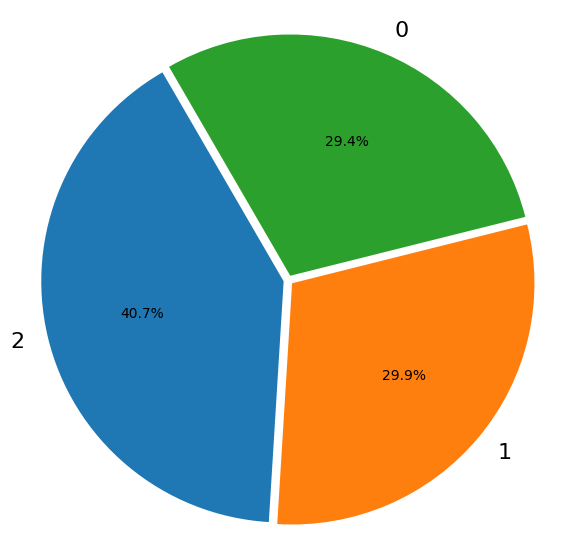

In [379]:
plt.figure(figsize=(7,7))
plt.pie(df.Rating.value_counts(),
        labels=df.Rating.value_counts().index,
        autopct='%1.1f%%',
        startangle=120, 
        explode=[0.02]*3)
plt.axis('equal')
plt.show()

In [380]:
df.Rating.describe()

count     10840
unique        3
top           2
freq       4411
Name: Rating, dtype: object

Checking for missing values:

In [381]:
df.Rating.isnull().sum()

0

<a id='size'></a>
#### Size

The information contained in Size is clearly numeric, however the column is categorical because it contains special characters.

In [382]:
df.Size.value_counts()

Size
Varies with device    1695
11M                    198
12M                    196
14M                    194
13M                    191
                      ... 
430k                     1
429k                     1
200k                     1
460k                     1
619k                     1
Name: count, Length: 461, dtype: int64

The size of applications is specified in megabytes and kilobytes. But the most common is the value 'Varies with device'.

Because of the characters M (megabytes) and K (kilobytes), *pandas* will not be able to automatically translate them into numbers and will throw an error. So, it's not possible just change the column type "Size" from object to float using the astype('float') method. 

Let's transfrom all values to the amount of megabytes and then to the number format.

**Task 4** Write a function that will receive one of the possible values of the Size column to the input, and will return either the corresponding number of megabytes or np.NaN. Use function [string.replace()](https://www.geeksforgeeks.org/python-string-replace/). 

*1Mb = 1024Kb*

In [383]:
### BEGIN SOLUTION
def check_size(size_value: str) -> float:
    if 'M' in size_value:
        return float(size_value.replace('M', ''))
    elif 'k' in size_value:
        return float(size_value.replace('k', '')) / 1024
    else:
        return np.NaN
### END SOLUTION
# def check_size(size_value):
#  write your code here  

Now let's apply our function to the Size column:

In [384]:
df.Size = df.Size.apply(check_size)

Let's check that the column is in the float format now:

In [385]:
assert df.Size.dtype == float
df.Size.dtype

dtype('float64')

All values 'Variations with device' are missing now.

In [386]:
df.Size.isnull().sum()/len(df)

0.15636531365313652

As you can see there is about 16% of the samples with NaN values (previously 'Variations with device'). That's quite a lot. To deal with this, we can create a new column with binary values that will store information about these NaN samples (perhaps this information will be useful) and then process them in the original column.

In [387]:
df['unknown_size'] = df.Size.isnull()

Now let's handle the missing values. There are several traditional methods to deal with them:

1. remove
2. replace with average, mode, median, 0
3. replace with nearby examples (mostly for time series data)
4. use the distribution of existing data and use it to generate new values for features. (useful when using linear models)
5. make this column a target variable and train a separate model to predict the missing values

The easiest option is to delete these rows. But 16% is a lot of samples. We don't want to lose so much useful information. The best way is to use a special model, but it can take a lot of time. Usually it's better to compare different approaches.

For this case we will use the median, but you can try experimenting with other options.

**Task 5** Fill in the missing values in the Size column with the median value of the same column. Use the methods [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) и [median](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.median.html)

In [388]:
### BEGIN SOLUTION
df.Size = df.Size.fillna(value=df.Size.median())
### END SOLUTION
# df.Size = df.Size.fillna(value=?)

Just in case, check that there are no empty values:

In [389]:
assert df.Size.isnull().sum() == 0
df.Size.isnull().sum()

0

<a id='type'></a>
#### Type

In [390]:
df.Type.value_counts(normalize=True)

Type
Free    0.926192
Paid    0.073808
Name: proportion, dtype: float64

93% of apps are free. To say more, you need to look at the relationships with other variables. We will deal with this in the next section. Let's check for missing values:

In [391]:
df.Type.isnull().sum()

1

There is one missing, let's inspect this one.

In [392]:
df[df.Type.isnull()]

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver,unknown_size
9148,Command & Conquer: Rivals,FAMILY,0,13.0,NaN,0,Everyone 10+,Strategy,Varies with device,Varies with device,True


**Task 6** Handle the instance with the missing "Type" in the way you think is best.

In [393]:
### BEGIN SOLUTION
# Column Price isn't empty and there is 0, so we can replace missing value in "Type" with "Free" value.
df.loc[df.Type.isnull(), 'Type'] = 'Free'
### END SOLUTION

In [394]:
assert df.Type.isnull().sum() == 0
df.Type.isnull().sum()

0

Well done!

Now let's see if you made the most optimal choice...

In [395]:
assert len(df) == 10840

<a id='price'></a>
#### Price

In [396]:
df.Price.value_counts()[:10]

Price
0        10040
$0.99      148
$2.99      129
$1.99       73
$4.99       72
$3.99       63
$1.49       46
$5.99       30
$2.49       26
$9.99       21
Name: count, dtype: int64

The variable is numeric, but it contains special characters. That's why it has 'object' Type.

**Task 7:** Remove the special character "$". Change the column type to 'float' using the method [astype()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html).

In [397]:
### BEGIN SOLUTION
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype('float')
### END SOLUTION
# df['Price'] = df['Price'].str.replace(?)
# df['Price'] = df['Price']. ?

assert df.Price.dtype == float

Let's create a distribution plot of prices among the paid apps.

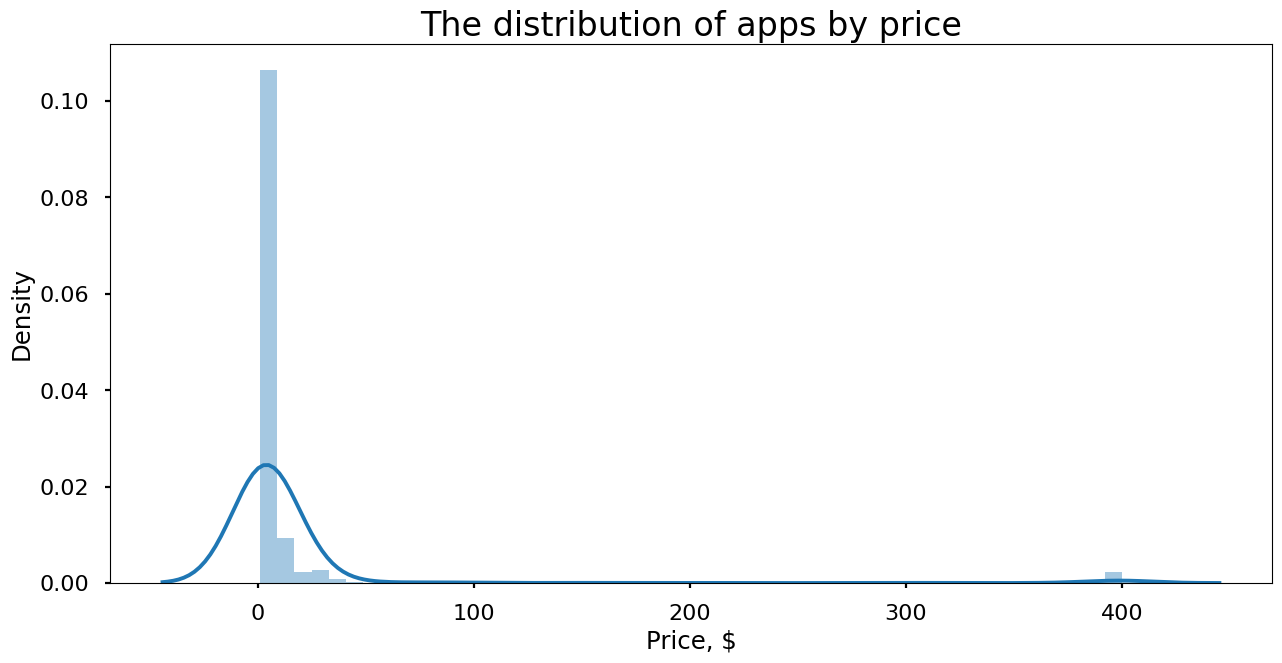

In [398]:
plt.figure(figsize=[15, 7])
sns.distplot(df.Price[df.Type == 'Paid'])
plt.xlabel("Price, $")
plt.title('The distribution of apps by price' ,size = 24)
plt.show()

Cheap apps make up the most part. Moreover, the rest of apps take too small part of all apps, so it is difficult to say anything by the graphic.

Let's look at logarithm of price. This will spread out the smaller values a bit more so it will be easier for us (and the model later on) to see the difference and the link with the rating.

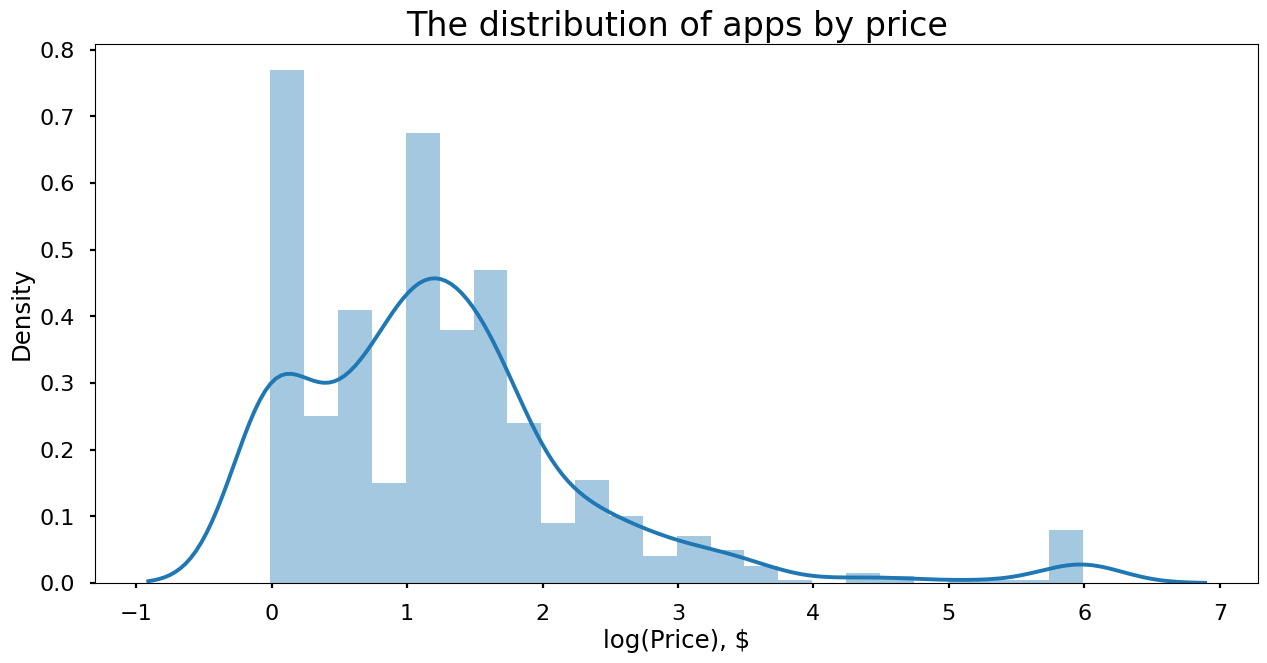

In [399]:
plt.figure(figsize=[15, 7])
sns.distplot(np.log(df.Price[df.Type == 'Paid']))
plt.xlabel("log(Price), $")
plt.title('The distribution of apps by price',size = 24)
plt.show()

Most apps cost around 1 and 3 dollars. The dispersion of values on the left part of the plot is due to the strong discreteness of small values of the original column. Let's have a look at the strange peak on the right side of the plot.

In [400]:
df[df.Price > 200]

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver,unknown_size
4197,most expensive app (H),FAMILY,0,1.500000,Paid,399.99,Everyone,Entertainment,1.0,7.0 and up,False
4362,💎 I'm rich,LIFESTYLE,1,26.000000,Paid,399.99,Everyone,Lifestyle,1.0.0,4.4 and up,False
4367,I'm Rich - Trump Edition,LIFESTYLE,1,7.300000,Paid,400.00,Everyone,Lifestyle,1.0.1,4.1 and up,False
5351,I am rich,LIFESTYLE,1,1.800000,Paid,399.99,Everyone,Lifestyle,2.0,4.0.3 and up,False
5354,I am Rich Plus,FAMILY,1,8.700000,Paid,399.99,Everyone,Entertainment,3.0,4.4 and up,False
5355,I am rich VIP,LIFESTYLE,1,2.600000,Paid,299.99,Everyone,Lifestyle,1.1.1,4.3 and up,False
5356,I Am Rich Premium,FINANCE,1,4.700000,Paid,399.99,Everyone,Finance,1.6,4.0 and up,False
5357,I am extremely Rich,LIFESTYLE,0,2.900000,Paid,379.99,Everyone,Lifestyle,1.0,4.0 and up,False
5358,I am Rich!,FINANCE,0,22.000000,Paid,399.99,Everyone,Finance,1.0,4.1 and up,False
5359,I am rich(premium),FINANCE,0,0.942383,Paid,399.99,Everyone,Finance,3.4,4.4 and up,False


Strange apps for the rich. Perhaps they are an indicator of status in certain circles or something like that.
Let's check for missing values and move on.

In [401]:
df.Price.isnull().sum()

0

<a id='content_rating'></a>
#### Content Rating

In [402]:
df['Content Rating'].value_counts()

Content Rating
Everyone           8714
Teen               1208
Mature 17+          499
Everyone 10+        414
Adults only 18+       3
Unrated               2
Name: count, dtype: int64

Remove the "Adults only 18+" and "Unrated classes". They are too few.

In [403]:
df = df[(df['Content Rating'] != 'Adults only 18+') & (df['Content Rating']!= 'Unrated')] 

In [404]:
df['Content Rating'].value_counts()

Content Rating
Everyone        8714
Teen            1208
Mature 17+       499
Everyone 10+     414
Name: count, dtype: int64

Check for missing.

In [405]:
df['Content Rating'].isnull().sum()

0

<a id='genres'></a>
#### Genres

In [406]:
df.Genres.value_counts()

Genres
Tools                                841
Entertainment                        622
Education                            549
Medical                              463
Business                             460
                                    ... 
Parenting;Brain Games                  1
Travel & Local;Action & Adventure      1
Lifestyle;Pretend Play                 1
Tools;Education                        1
Strategy;Creativity                    1
Name: count, Length: 119, dtype: int64

THere are quite a lot of genres - 119. Moreover, some of them are actually a result of combining two basic genres. Let's find out the amount of unique ones.

In [407]:
list_of_genres = []
for i in df.Genres.str.split(';').values:
    list_of_genres.extend(i)
print('Amount of subcategory: {}'.format(len(set(list_of_genres))))

Amount of subcategory: 53


**Task 8** Calculate the amount of genres for each app and estimate the general distribution for them? Use [series.str.findall()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.findall.html)

Tip: use the apply function to find the length to keep this a one-liner.

In [408]:
### BEGIN SOLUTION
counts_of_genres = df.Genres.str.findall(';').apply(len) + 1
### END SOLUTION
# counts_of_genres = df.Genres.str.findall ?

assert sum(counts_of_genres) == 11333

In [409]:
counts_of_genres.describe()

count    10835.000000
mean         1.045962
std          0.209413
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Genres, dtype: float64

In [410]:
(counts_of_genres>1).sum()/len(counts_of_genres)

0.045962159667743425

There isn't a lot of applications with many genres. Let's look at some of them.

In [411]:
df[counts_of_genres>1].head(10)

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Current Ver,Android Ver,unknown_size
1,Coloring book moana,ART_AND_DESIGN,1,14.0,Free,0.0,Everyone,Art & Design;Pretend Play,2.0.0,4.0.3 and up,False
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,1,2.8,Free,0.0,Everyone,Art & Design;Creativity,1.1,4.4 and up,False
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,1,3.1,Free,0.0,Everyone,Art & Design;Creativity,2.8,4.0.3 and up,False
23,Mcqueen Coloring pages,ART_AND_DESIGN,1,7.0,Free,0.0,Everyone,Art & Design;Action & Adventure,1.0.0,4.1 and up,False
26,Colorfit - Drawing & Coloring,ART_AND_DESIGN,1,25.0,Free,0.0,Everyone,Art & Design;Creativity,1.0.8,4.0.3 and up,False
36,UNICORN - Color By Number & Pixel Art Coloring,ART_AND_DESIGN,1,24.0,Free,0.0,Everyone,Art & Design;Creativity,1.0.9,4.4 and up,False
43,Paint Splash!,ART_AND_DESIGN,1,1.2,Free,0.0,Everyone,Art & Design;Creativity,1.46,4.1 and up,False
301,Unicorn Pokez - Color By Number,COMICS,1,12.0,Free,0.0,Everyone,Comics;Creativity,1.0.6,4.4 and up,False
699,Duolingo: Learn Languages Free,EDUCATION,2,13.0,Free,0.0,Everyone,Education;Education,Varies with device,Varies with device,True
705,Princess Coloring Book,EDUCATION,2,39.0,Free,0.0,Everyone,Education;Creativity,1.2.8,4.0 and up,False


You may notice that the genre column often contains the same as the category column. We will explore this in more detail later. Now let's check for missing values and move on.

In [412]:
df.Genres.isnull().sum()

0

<a id='current_ver'></a>
#### Current Version

In [413]:
df['Current Ver'].value_counts()

Current Ver
Varies with device    1458
1.0                    809
1.1                    264
1.2                    178
2.0                    151
                      ... 
0.8.17                   1
1.0.17.3905              1
15.1.2                   1
4.94.19                  1
2.0.148.0                1
Name: count, Length: 2829, dtype: int64

Because of too many unique values, this isn't a particularly informative column. It seems that each developer uses its own notation, so we will just remove it.

In [414]:
df = df.drop(columns=['Current Ver'])

<a id='android_ver'></a>
#### Android Version

In [415]:
df['Android Ver'].value_counts(normalize=True)

Android Ver
4.1 and up            0.226161
4.0.3 and up          0.138558
4.0 and up            0.126927
Varies with device    0.125635
4.4 and up            0.090372
2.3 and up            0.060186
5.0 and up            0.055479
4.2 and up            0.036370
2.3.3 and up          0.025847
2.2 and up            0.022524
4.3 and up            0.022431
3.0 and up            0.022155
2.1 and up            0.012370
1.6 and up            0.010708
6.0 and up            0.005539
7.0 and up            0.003877
3.2 and up            0.003323
2.0 and up            0.002954
5.1 and up            0.002215
1.5 and up            0.001846
4.4W and up           0.001108
3.1 and up            0.000923
2.0.1 and up          0.000646
8.0 and up            0.000554
7.1 and up            0.000277
4.0.3 - 7.1.1         0.000185
5.0 - 8.0             0.000185
1.0 and up            0.000185
7.0 - 7.1.1           0.000092
4.1 - 7.1.1           0.000092
5.0 - 6.0             0.000092
2.2 - 7.1.1           0.000

In [416]:
df['Android Ver'].isnull().sum()

2

There are 2 missing values. Remove it.

In [417]:
df = df.dropna(subset=['Android Ver'])

Let's cluster them together in bigger classes.

In [418]:
for i in range(1, 9):
    df.loc[df['Android Ver'].str.contains('^{}..*'.format(i)), 'Android Ver'] = '{} and up'.format(i)

In [419]:
df['Android Ver'].value_counts(normalize=True).sort_index()

Android Ver
1 and up              0.012739
2 and up              0.124619
3 and up              0.026401
4 and up              0.642204
5 and up              0.058063
6 and up              0.005539
7 and up              0.004246
8 and up              0.000554
Varies with device    0.125635
Name: proportion, dtype: float64

Groups 1-3 and 5-8 still have a small number of examples. The biggest one is 4 group. We probably should cluster the classes even more and combine 1-3 and 5-8 into two separate groups.

In [420]:
df.loc[df['Android Ver'].str.contains('^[123]..*'), 'Android Ver'] = '1 and up'
df.loc[df['Android Ver'].str.contains('^[5678]..*'), 'Android Ver'] = '5 and up'

In [421]:
df['Android Ver'].value_counts(normalize=True)

Android Ver
4 and up              0.642204
1 and up              0.163759
Varies with device    0.125635
5 and up              0.068402
Name: proportion, dtype: float64

With such distribution of values, this feature can actually contribute to the model.

In [422]:
df['Android Ver'].isnull().sum()

0

<a id='final_check'></a>
#### Final check

Сheck if there are missing values in the dataset.

In [423]:
df.isnull().sum()

App               0
Category          0
Rating            0
Size              0
Type              0
Price             0
Content Rating    0
Genres            0
Android Ver       0
unknown_size      0
dtype: int64

<a id='removing_duplicates'></a>
### 1.3. Removing duplicates

Now we should make sure there are no applications that occur in the dataset more than once, or in other words - duplicate each other.

In [424]:
df_dup = df[df.duplicated(subset='App')]

In [425]:
df_dup.head()

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Android Ver,unknown_size
229,Quick PDF Scanner + OCR FREE,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True
236,Box,BUSINESS,2,13.0,Free,0.0,Everyone,Business,Varies with device,True
239,Google My Business,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True
256,ZOOM Cloud Meetings,BUSINESS,2,37.0,Free,0.0,Everyone,Business,4 and up,False
261,join.me - Simple Meetings,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True


In [426]:
dup_apps = ['Quick PDF Scanner + OCR FREE', 'Box', 'Call Blocker', 'Bubble Shooter', 'Word Search']

df_tmp = pd.DataFrame()
for col in dup_apps:
    df_tmp = pd.concat((df_tmp, df[df.App == col]))
df_tmp

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Android Ver,unknown_size
222,Quick PDF Scanner + OCR FREE,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True
229,Quick PDF Scanner + OCR FREE,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True
285,Quick PDF Scanner + OCR FREE,BUSINESS,2,13.0,Free,0.0,Everyone,Business,4 and up,True
204,Box,BUSINESS,2,13.0,Free,0.0,Everyone,Business,Varies with device,True
236,Box,BUSINESS,2,13.0,Free,0.0,Everyone,Business,Varies with device,True
265,Box,BUSINESS,2,13.0,Free,0.0,Everyone,Business,Varies with device,True
206,Call Blocker,BUSINESS,2,3.2,Free,0.0,Everyone,Business,4 and up,False
436,Call Blocker,COMMUNICATION,2,10.0,Free,0.0,Everyone,Communication,4 and up,False
1657,Bubble Shooter,GAME,2,46.0,Free,0.0,Everyone,Casual,4 and up,False
1711,Bubble Shooter,GAME,2,46.0,Free,0.0,Everyone,Casual,4 and up,False


Some applications have duplicates with different sizes, so we’ll sort by size

In [427]:
df = df.sort_values('Size')

**Task 9** Remove duplicates with [drop_duplicates()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) (keep applications with the largest size)

In [428]:
### BEGIN SOLUTION
df = df.drop_duplicates(subset=['App'], keep='last')
### END SOLUTION
# df = df.drop_duplicates(?)

In [429]:
assert df.shape == (9652, 10)

df.shape

(9652, 10)

After filtering, we lost ~11% from the total volume of our dataset. Obviously this is an unpleasant measure, but it has to be done.

In [430]:
df.head()

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Android Ver,unknown_size
1532,Essential Resources,LIBRARIES_AND_DEMO,1,0.008301,Free,0.00,Everyone,Libraries & Demo,5 and up,False
1553,Market Update Helper,LIBRARIES_AND_DEMO,2,0.010742,Free,0.00,Everyone,Libraries & Demo,1 and up,False
4983,My baby firework (Remove ad),FAMILY,0,0.013672,Paid,0.99,Everyone,Entertainment,Varies with device,False
10072,ExDialer PRO Key,COMMUNICATION,1,0.016602,Paid,3.99,Everyone,Communication,1 and up,False
4977,Ad Remove Plugin for App2SD,PRODUCTIVITY,0,0.016602,Paid,1.29,Everyone,Productivity,1 and up,False


<a id='2_data_relations'></a>
## 2. Exploring the relationship between variables

<a id='numerical_features'></a>
###  2.1. Numerical features

One of the simple and effective methods to explore the relationship between numerical features is correlation analysis. 

> **Correlation**  - is a statistical relationship between two or more random variables (or variables that can be considered as random with some acceptable degree of accuracy). Changes in one or more values lead to a systematic changing of another values.

A correlation matrix is a matrix that contains the values of correlations between variables. In our case the correlation values between all pairs of numerical features will be obtained.

<img src="./images/Correlation_examples.png">

The image above give you some insight into what the correlation values mean. As you can see this only works in sort of a straight line. Non-linear correlations, as shown in the bottom row, are not captured by this method.

In [431]:
# # Store solutions of previous exercise
# df.to_parquet('data/feature_engineering_ex1.parquet')

# Load data from previous exercise
df = pd.read_parquet('data/feature_engineering_ex1.parquet')

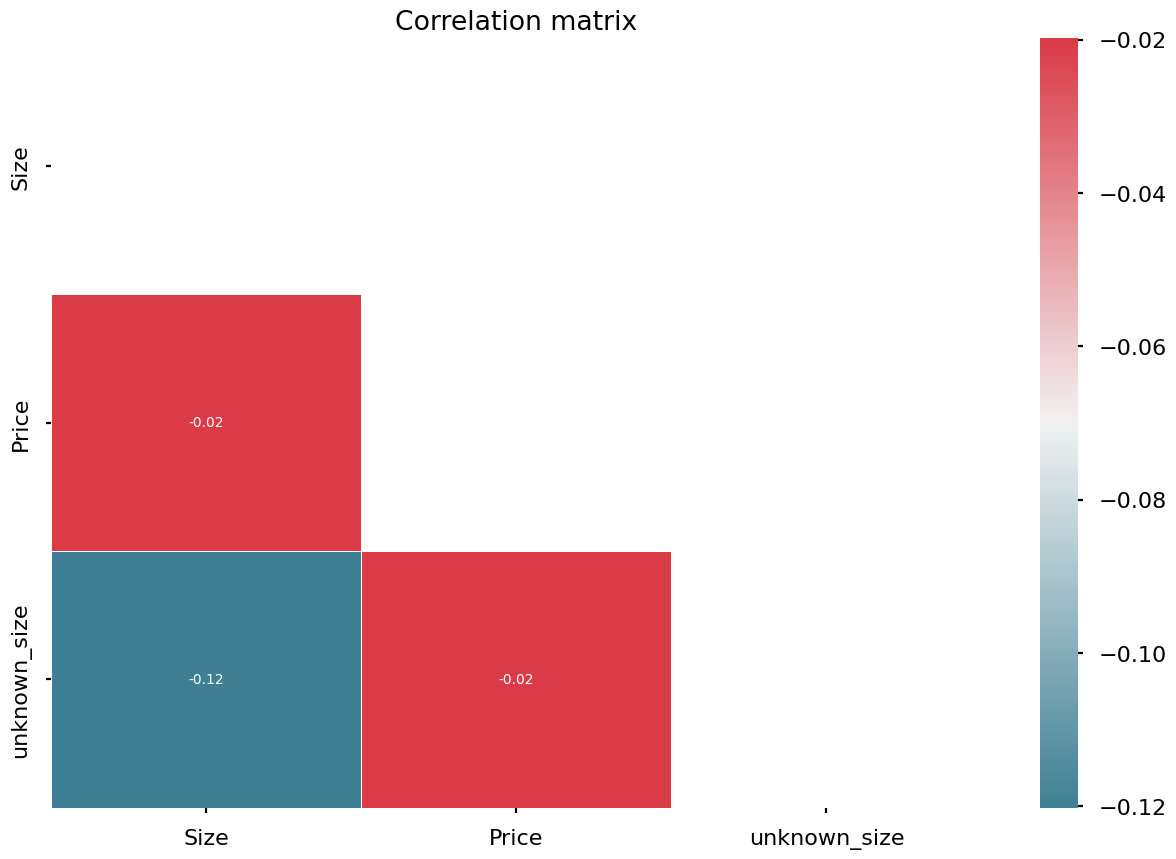

In [432]:
corr_df = df.corr(numeric_only=True)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
mask = np.zeros_like(corr_df, dtype=bool)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=[15,10])
plt.title('Correlation matrix')
sns.heatmap(corr_df, mask=mask, cmap=cmap, linewidths=.5, annot=True)
plt.show()

+ There is no correlation between the numeric variables.

As the next step we will use *pairplot* method for our numeric variables. In order to be able to tell something we shall consider *price* on a logarithmic scale. Let's make a separate dataframe for this.

In [433]:
df_log = df.copy()
df_log['log_price'] = np.log1p(df_log.Price)
df_log.unknown_size = df_log.unknown_size.astype(int)

*Pairplots* compares the distributions of variables in pairs and allow you to make the most common assumptions, which can then be checked and clarified later.
 
The distributions of the variables are shown on the diagonal with a color breakdown by the selected types. Relations between two variables are drawn above and below the diagonal: each point is one application in our case.

By default, pairplots use KDE. But it is often built incorrectly - instead of smooth "bells" there are thin high peaks, ridges and other artefacts. Therefore, the using of histograms is more reliable.

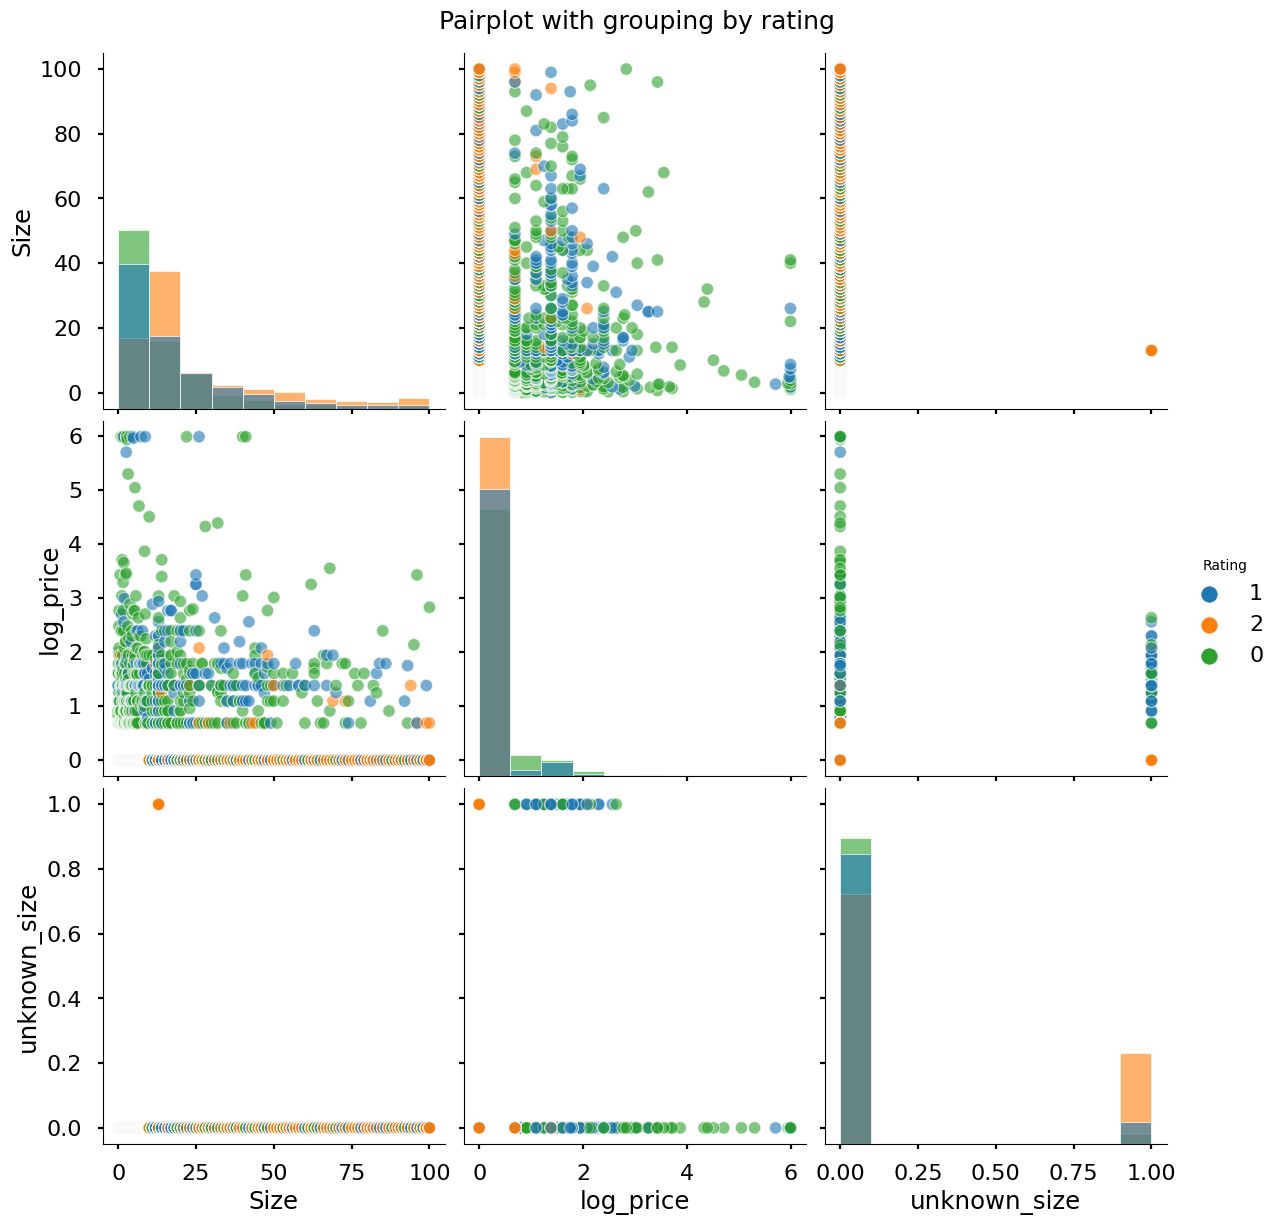

In [434]:
ax = sns.pairplot(df_log, hue='Rating', 
                  vars = ['Size', 'log_price', 'unknown_size'],
                  plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'w'},
                  diag_kind='hist', diag_kws = {'edgecolor': 'w', 'alpha': 0.6, 'bins': 10}, 
                  size = 4)
ax.fig.suptitle('Pairplot with grouping by rating', y=1.02, size=18)
plt.show()

**Task 10:** Explore the graphics. What conclusions can you make?

**Answer** We can see from graphics the following:
+ Applications with a small size and "0" rating are more frequent than others. Applications with other sizes have more instances with rating "2" 
+ No apps with big size and high price
+ Apps with "2" rating mostly have low prices. The peak on the 2nd basket probably occurred due to the replacement of missing "size" samples with the median.
+ Applications with "2" rating stand out among the applications whose size depends on the device 

<a id='app_len_&_rating'></a>
### 2.2. Application length and rating

Let's see how the length of the application name affects the rating. To do this, create a separate dataframe with the App and Rating columns. As a result we will receive a column with the length of the application name.

In [435]:
df_app = pd.DataFrame({'App': df.App,
                       'Rating': df.Rating})
df_app['App_len'] = df_app.App.apply(len)

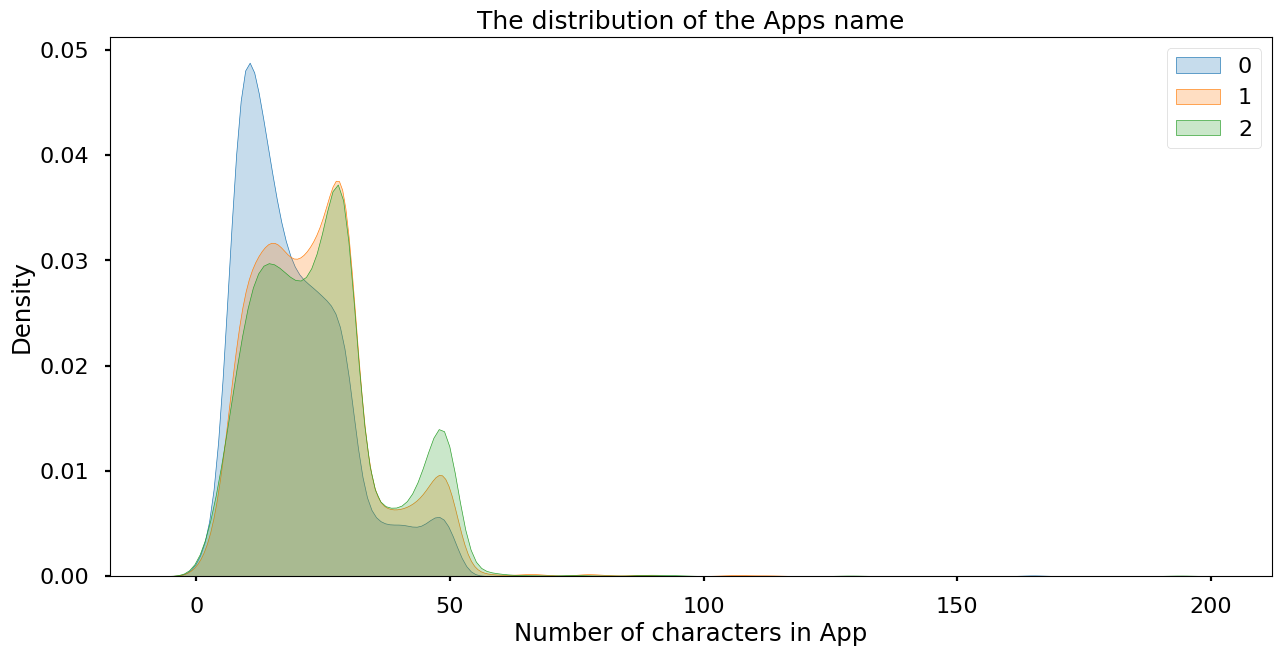

In [436]:
plt.figure(figsize=(15, 7))
for i in sorted(df_app.Rating.unique()):
    sns.kdeplot(df_app.App_len[df_app.Rating==i],
                shade=True,
                legend=False,)
plt.legend(labels=sorted(df_app.Rating.unique()))
plt.xlabel("Number of characters in App")
plt.title("The distribution of the Apps name",size = 18)
plt.show()

Apps with "0" rating are more likely to have a short title. At the same time, more popular applications are in the range of 20 to 50 characters.

<a id='type_&_price'></a>
### 2.3. Price and Type

It is logical to assume that if "Type" is "Free", then "Price" should be equal to zero.

Let's group "Type" and look at the average price in each group ("Free" and "Paid").

In [437]:
df.groupby('Type')['Price'].mean()

Type
Free     0.000000
Paid    14.071154
Name: Price, dtype: float64

The average price of a "Free" app is zero dollars, a paid one is 14 dollars. Looks fine.

<a id='category_&_genres'></a>
###  2.4. Category and Genres

Genres is a subsection of Category.

In [438]:
df.head(5)

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Android Ver,unknown_size
1532,Essential Resources,LIBRARIES_AND_DEMO,1,0.008301,Free,0.00,Everyone,Libraries & Demo,5 and up,False
1553,Market Update Helper,LIBRARIES_AND_DEMO,2,0.010742,Free,0.00,Everyone,Libraries & Demo,1 and up,False
4983,My baby firework (Remove ad),FAMILY,0,0.013672,Paid,0.99,Everyone,Entertainment,Varies with device,False
10072,ExDialer PRO Key,COMMUNICATION,1,0.016602,Paid,3.99,Everyone,Communication,1 and up,False
4977,Ad Remove Plugin for App2SD,PRODUCTIVITY,0,0.016602,Paid,1.29,Everyone,Productivity,1 and up,False


Let's see which categories use the most subcategories.
Next we will aggregate categories and genres in a separate table and make a new column with the number of genres.

In [439]:
df_cat_genrs = df[['Category', 'Genres', 'Rating']]
df_cat_genrs['Count_of_genres'] = df_cat_genrs.Genres.str.findall(';').apply(len)+1
df_cat_genrs.head()

,Category,Genres,Rating,Count_of_genres
1532,LIBRARIES_AND_DEMO,Libraries & Demo,1,1
1553,LIBRARIES_AND_DEMO,Libraries & Demo,2,1
4983,FAMILY,Entertainment,0,1
10072,COMMUNICATION,Communication,1,1
4977,PRODUCTIVITY,Productivity,0,1


**Task 11** Explore the genre number statistics for each category. Use [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [describe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html).

In [440]:
### BEGIN SOLUTION
group_df = df_cat_genrs.groupby('Category')['Count_of_genres'].describe().sort_values('mean', ascending=False)
### END SOLUTION
# group_df = df_cat_genrs.groupby( ? )[ ? ].describe().sort_values('mean', ascending=False)
group_df.head(15)

,count,mean,std,min,25%,50%,75%,max
Category,,,,,,,,
PARENTING,60.0,1.233333,0.426522,1.0,1.0,1.0,1.0,2.0
FAMILY,1872.0,1.185363,0.388696,1.0,1.0,1.0,1.0,2.0
EDUCATION,109.0,1.110092,0.314450,1.0,1.0,1.0,1.0,2.0
ART_AND_DESIGN,63.0,1.095238,0.295901,1.0,1.0,1.0,1.0,2.0
ENTERTAINMENT,88.0,1.068182,0.253502,1.0,1.0,1.0,1.0,2.0
COMICS,54.0,1.018519,0.136083,1.0,1.0,1.0,1.0,2.0
VIDEO_PLAYERS,163.0,1.006135,0.078326,1.0,1.0,1.0,1.0,2.0
TRAVEL_AND_LOCAL,219.0,1.004566,0.067574,1.0,1.0,1.0,1.0,2.0
GAME,942.0,1.004246,0.065060,1.0,1.0,1.0,1.0,2.0


The maximum number of subcategories in one category is 2, the minimum is 1. Two subcategories are most often found in the categories PARENTING, FAMILY, EDUCATION. Only 11 categories have multiple genres.

Categories and genres often overlap. Let's study this more in detail.

For starters we should bring categories and genres to a common format: transform them into lower case (*str.lower()*) and remove special characters (replace the special characters with spaces or nothing using the *str.replace()*).


_**Note:** pandas has many methods for working with strings. You can read more about them in the documentation_
[Working with Text Data](https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html).

In [441]:
df_cat_genrs.Category = df_cat_genrs.Category.str.lower()
df_cat_genrs.Genres = df_cat_genrs.Genres.str.lower()
df_cat_genrs.Genres = df_cat_genrs.Genres.str.replace('&', '')
df_cat_genrs.Genres = df_cat_genrs.Genres.str.replace(';', ' ')
df_cat_genrs.Category = df_cat_genrs.Category.str.replace('_', ' ')
df_cat_genrs.Category = df_cat_genrs.Category.str.replace('and', '')

In [442]:
df_cat_genrs.head(5)

,Category,Genres,Rating,Count_of_genres
1532,libraries demo,libraries demo,1,1
1553,libraries demo,libraries demo,2,1
4983,family,entertainment,0,1
10072,communication,communication,1,1
4977,productivity,productivity,0,1


Let's calculate how many apps have the same genres and categories. 

In [443]:
(df_cat_genrs['Category'] == df_cat_genrs['Genres']).sum()/len(df_cat_genrs)

0.6872150849564858

The columns are completely the same for almost 70%. That is, 70% of the values don't contain new information. Most likely, there are more matches considering possible errors related to usage of regular expressions on raw data.

Let's add a column to indicate whether the genre is equal to the category or not.

In [444]:
df_cat_genrs['is_cat_equal_genre'] = df_cat_genrs['Category'] == df_cat_genrs['Genres']
df_cat_genrs.head()

,Category,Genres,Rating,Count_of_genres,is_cat_equal_genre
1532,libraries demo,libraries demo,1,1,True
1553,libraries demo,libraries demo,2,1,True
4983,family,entertainment,0,1,False
10072,communication,communication,1,1,True
4977,productivity,productivity,0,1,True


**Task 12** Explore whether there is a difference between distributions of apps with the same and with different categories and genres (use [sns.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)).

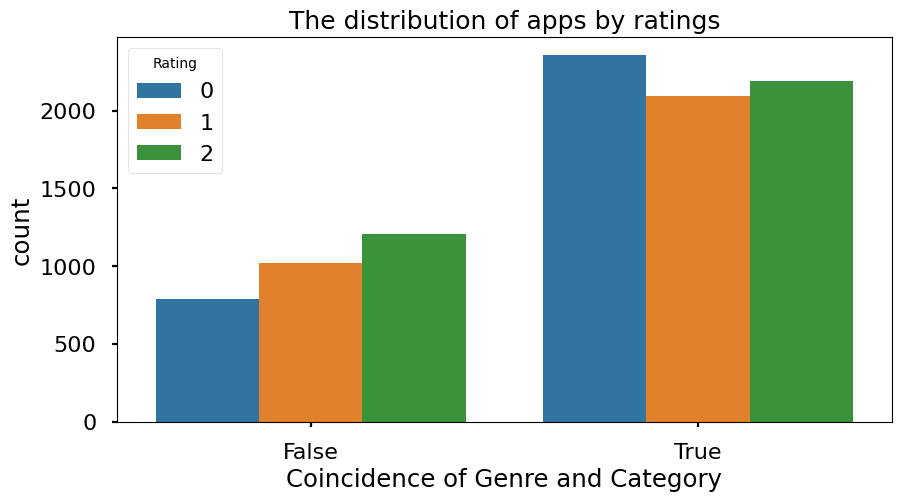

In [445]:
plt.figure(figsize=(10, 5))

### BEGIN SOLUTION
sns.countplot(x="is_cat_equal_genre",  hue='Rating', data=df_cat_genrs, hue_order=np.sort(df['Rating'].unique()))
### END SOLUTION
# sns.countplot(x= ?,  hue='Rating', data=df_cat_genrs, hue_order=np.sort(df['Rating'].unique()))

plt.xlabel("Coincidence of Genre and Category")
plt.title('The distribution of apps by ratings',size = 18)
plt.show()

The rating distributions for True and False are slightly different. You can see that applications with a rating 0 stand out a little bit. To numerically estimate this distribution, we will use the contingency table.

In [446]:
cr_tab = pd.crosstab(df_cat_genrs.Rating, df_cat_genrs.is_cat_equal_genre)
cr_tab

is_cat_equal_genre,False,True
Rating,,
0,790,2354
1,1023,2090
2,1206,2189


In [447]:
cr_tab / cr_tab.min()

is_cat_equal_genre,False,True
Rating,,
0,1.000000,1.126316
1,1.294937,1.000000
2,1.526582,1.047368


The difference in distribution for apps with same category and genre is negligible. On the other side, applications with different genre and category are 1.5 times more likely to have "2" rating.

Such column could be useful in predicting the rating of applications. At the same time there is little sense to leave two columns with almost the same information. That's why we remove the column genre and add column is_cat_equal_genre in the main dataset.

In [448]:
df = df.drop(columns=['Genres'])
df['is_cat_equal_genre'] = df_cat_genrs['is_cat_equal_genre'] 

<a id='rating_&_content_rating'></a>
### 2.5. Rating and Content Rating

**Task 13** Explore the relationship between rating and content rating columns.

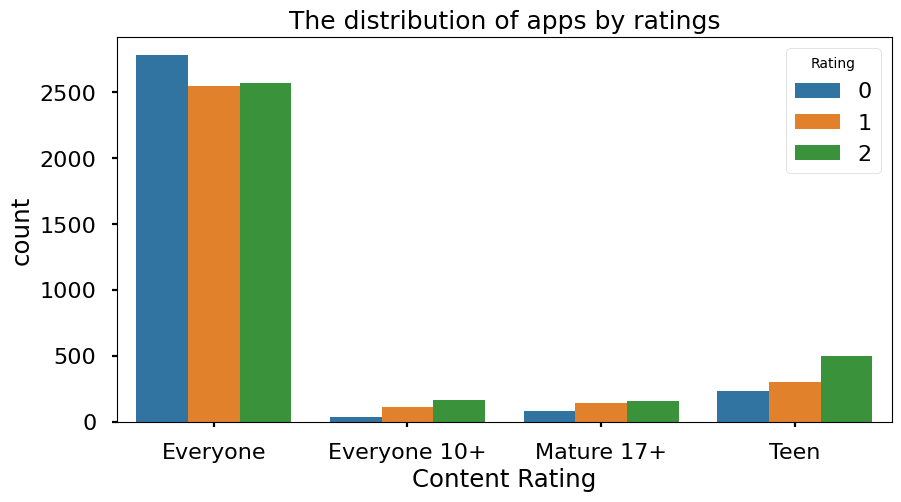

In [449]:
plt.figure(figsize=(10, 5))

### BEGIN SOLUTION
sns.countplot(x='Content Rating', hue='Rating', data=df, hue_order=np.sort(df['Rating'].unique()))
### END SOLUTION
# sns.countplot(x= ?, hue= ?, data=df, hue_order=np.sort(df['Rating'].unique()))

plt.xlabel("Сontent Rating")
plt.title('The distribution of apps by ratings',size = 18)
plt.show()

In [450]:
### BEGIN SOLUTION
df_ct_rc = pd.crosstab(df.Rating, df['Content Rating'])
### END SOLUTION
# df_ct_rc = pd.crosstab(?, ?)

df_ct_rc /= df_ct_rc.sum()
df_ct_rc

Content Rating,Everyone,Everyone 10+,Mature 17+,Teen
Rating,,,,
0,0.351981,0.121118,0.221374,0.228764
1,0.322871,0.357143,0.368957,0.291506
2,0.325149,0.521739,0.409669,0.479730


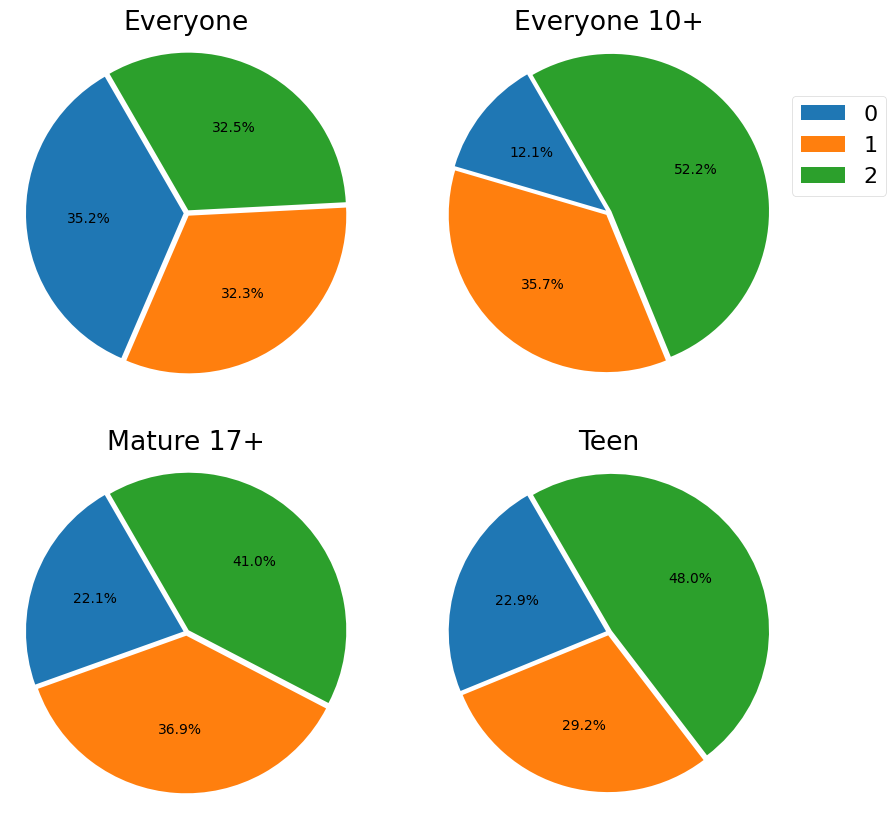

In [451]:
plt.figure(figsize=(10,10))
for i, con_rating in enumerate(df['Content Rating'].unique()):
    plt.subplot(2, 2, i+1)
    vc = df.Rating[df['Content Rating']== con_rating].value_counts().sort_index()
    patches = plt.pie(vc,  autopct='%1.1f%%', 
           startangle=120, explode=[0.02]*3)
    plt.title(con_rating)
    plt.axis('equal')
plt.legend(labels=vc.index, loc=(1.02,1.75))

   
plt.show()

Let's look at the table of both at the rating contingency with Content Rating column and the is_not_equal_genre column.

In [452]:
pd_ct_comp = pd.crosstab(df.Rating, [df['Content Rating'], df.is_cat_equal_genre])
pd_ct_comp /= pd_ct_comp.sum()
pd_ct_comp = pd_ct_comp.style.background_gradient(cmap='summer_r')
pd_ct_comp

First thing you could notice are applications with the age rating "Everyone" and the same categories and genres. For those application the most common rating is "0". Apps with Everyone 10+ and is_not_equal_genre False  mostly have rating "2".  
The most interesting thing is that the distribution of the rating for Teen and Mature 17+ applications  are fairly the same in general, they have a different distribution for applications with the same genre and category (*is_cat_equal_genre* True).

<a id='category_&_price'></a>
### 2.6. Category and Price

Another convenient way to explore the data distribution is a *catplot*. In its simplest, it allows you to display each individual example in an individual column. This way you can get a sense of the data density. 

We will use the previously created logarithmic price column and consider only paid applications and categories with at least 10 such applications.

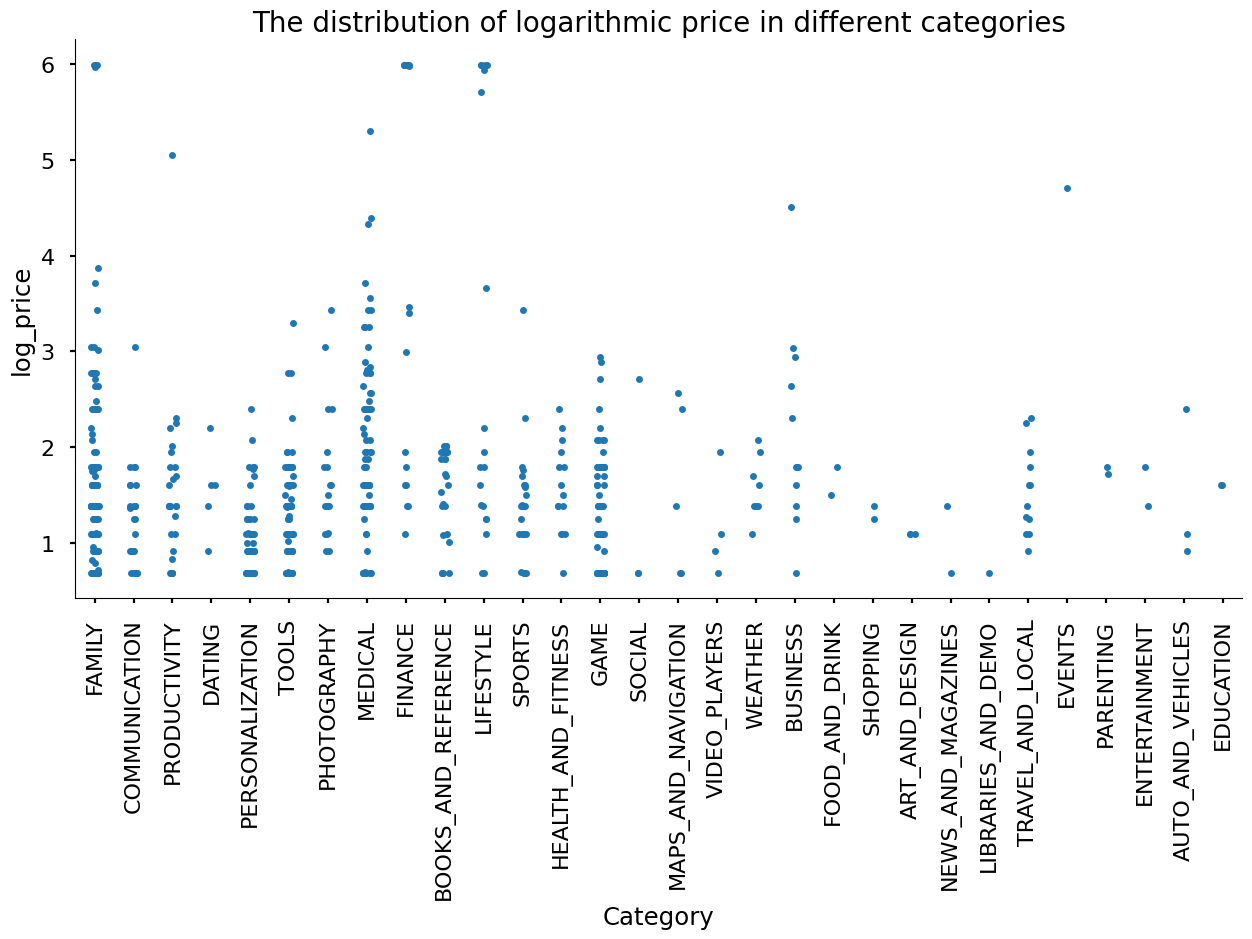

In [453]:
g = sns.catplot(x="Category",y="log_price", data=df_log[df_log.Type=='Paid'])
g.fig.set_figheight(7)
g.fig.set_figwidth(20)
plt.title('The distribution of logarithmic price in different categories', size = 20)
plt.xticks(rotation=90)
plt.show()

There are not a lot of paid applications, but numerous categories, so the graphics are so sparse. You can see that some categories have outlier applications: for instance, Communication category applications are mostly grouped together but one stands out from the others. Finance and Lifestyle are also quite sparse. Note, that the Family group contains a group of detached expensive applications.

Now will take a look at the same distributions, but using confidence intervals.
>**Confidence Intervals** - is a type of interval estimate used in statistics that are calculated for a given level of significance. They allow us to make a statement that the true value of an unknown statistical parameter of the general population is in the obtained range of values with a probability that is given by the selected level of statistical significance.

>What is the practical meaning of the confidence interval?

>+ A wide confidence interval indicates that the sample average doesn't accurately approximate the general average. This is usually related to an insufficient sample size, or to its heterogeneity, i.e. the large variance. Both give a large average error and, correspondingly, a wide confidence interval. This is the reason for returning to the planning stage of the study. 

>+ The upper and lower limits of the confidence interval give an estimation of whether the results will be statistically significant or not.

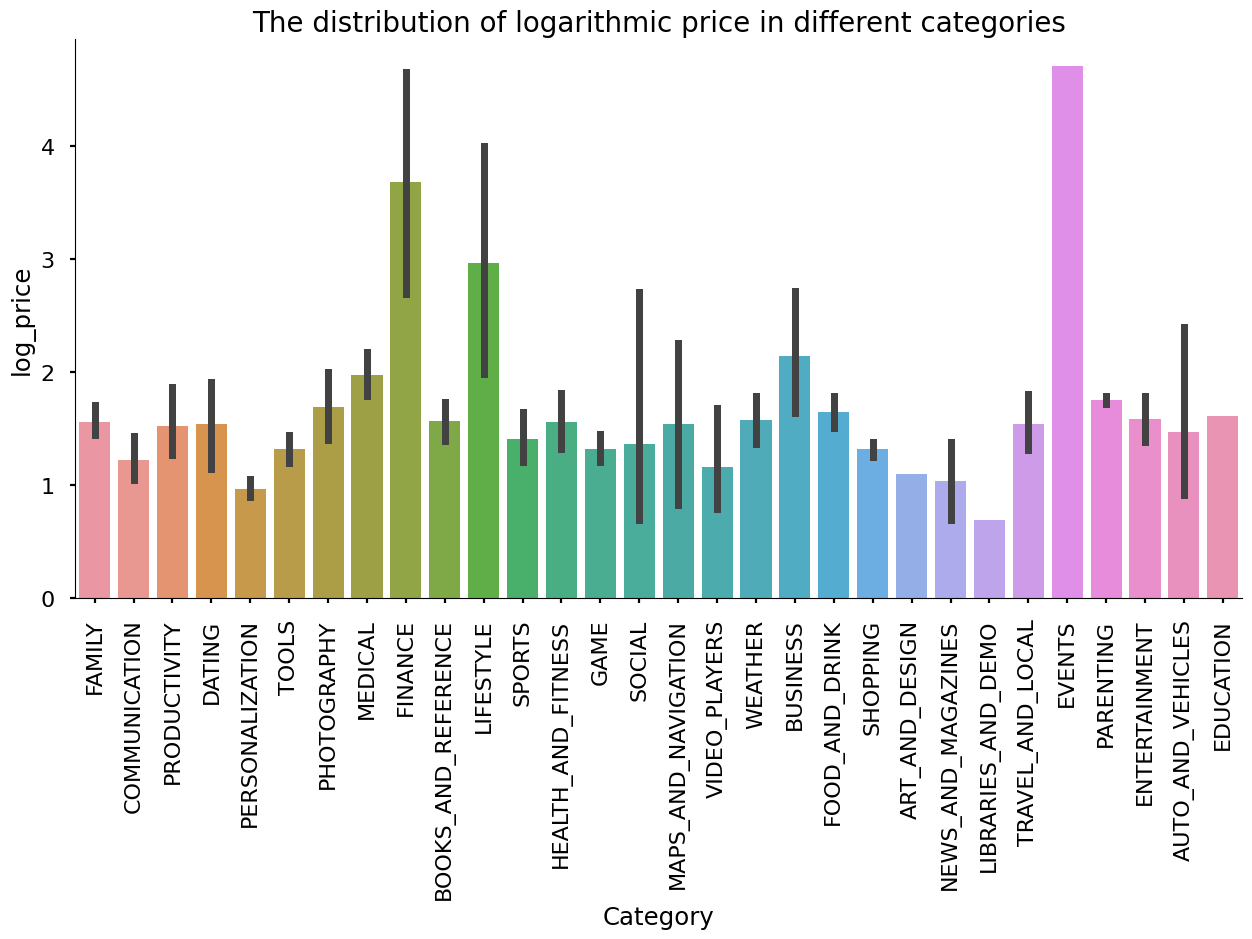

In [454]:
g = sns.catplot(x="Category",y="log_price", data=df_log[df_log.Type=='Paid'], kind='bar')
g.fig.set_figheight(7)
g.fig.set_figwidth(20)
plt.title('The distribution of logarithmic price in different categories', size = 20)
plt.xticks(rotation=90)
plt.show()

In this graph, the column height shows the average value, and the bar shows the confidence interval. You can notice that the Finance and Lifestyle categories have a very wide confidence interval. This means that these categories are highly sparse and have some isolated groups in different parts of the distributions. It is not valid to use the average value for such categories. There is no sense to consider other categories with a wide confidence interval - there are too few examples to interpret the stats meaningfully.

The Family category has a narrow confidence interval: although there is a separate group of expensive applications, their number is small and the distribution of prices in this category is uniform in general.

Let's look at the groups of expensive applications in the categories Finance and Lifestyle

In [455]:
df_log.log_price[(df_log.Category.isin(['LIFESTYLE', 'FINANCE'])) & (df_log.Type == 'Paid')].describe()

count    36.000000
mean      3.305204
std       2.135020
min       0.688135
25%       1.393131
50%       2.070297
75%       5.993936
max       5.993961
Name: log_price, dtype: float64

In [456]:
df_log[(df_log.log_price > 5.) & (df_log.Category.isin(['LIFESTYLE', 'FINANCE']))]

,App,Category,Rating,Size,Type,Price,Content Rating,Genres,Android Ver,unknown_size,log_price
5359,I am rich(premium),FINANCE,0,0.942383,Paid,399.99,Everyone,Finance,4 and up,0,5.993936
9917,Eu Sou Rico,FINANCE,0,1.400000,Paid,394.99,Everyone,Finance,4 and up,0,5.981389
5351,I am rich,LIFESTYLE,1,1.800000,Paid,399.99,Everyone,Lifestyle,4 and up,0,5.993936
5355,I am rich VIP,LIFESTYLE,1,2.600000,Paid,299.99,Everyone,Lifestyle,4 and up,0,5.707077
5364,I am rich (Most expensive app),FINANCE,0,2.700000,Paid,399.99,Teen,Finance,4 and up,0,5.993936
5357,I am extremely Rich,LIFESTYLE,0,2.900000,Paid,379.99,Everyone,Lifestyle,4 and up,0,5.942773
5369,I am Rich,FINANCE,0,3.800000,Paid,399.99,Everyone,Finance,4 and up,0,5.993936
5356,I Am Rich Premium,FINANCE,1,4.700000,Paid,399.99,Everyone,Finance,4 and up,0,5.993936
4367,I'm Rich - Trump Edition,LIFESTYLE,1,7.300000,Paid,400.00,Everyone,Lifestyle,4 and up,0,5.993961
5358,I am Rich!,FINANCE,0,22.000000,Paid,399.99,Everyone,Finance,4 and up,0,5.993936


The shift was due to a few expensive "freaky" apps we already saw earlier. Let's remove them and rearrange the graphic.

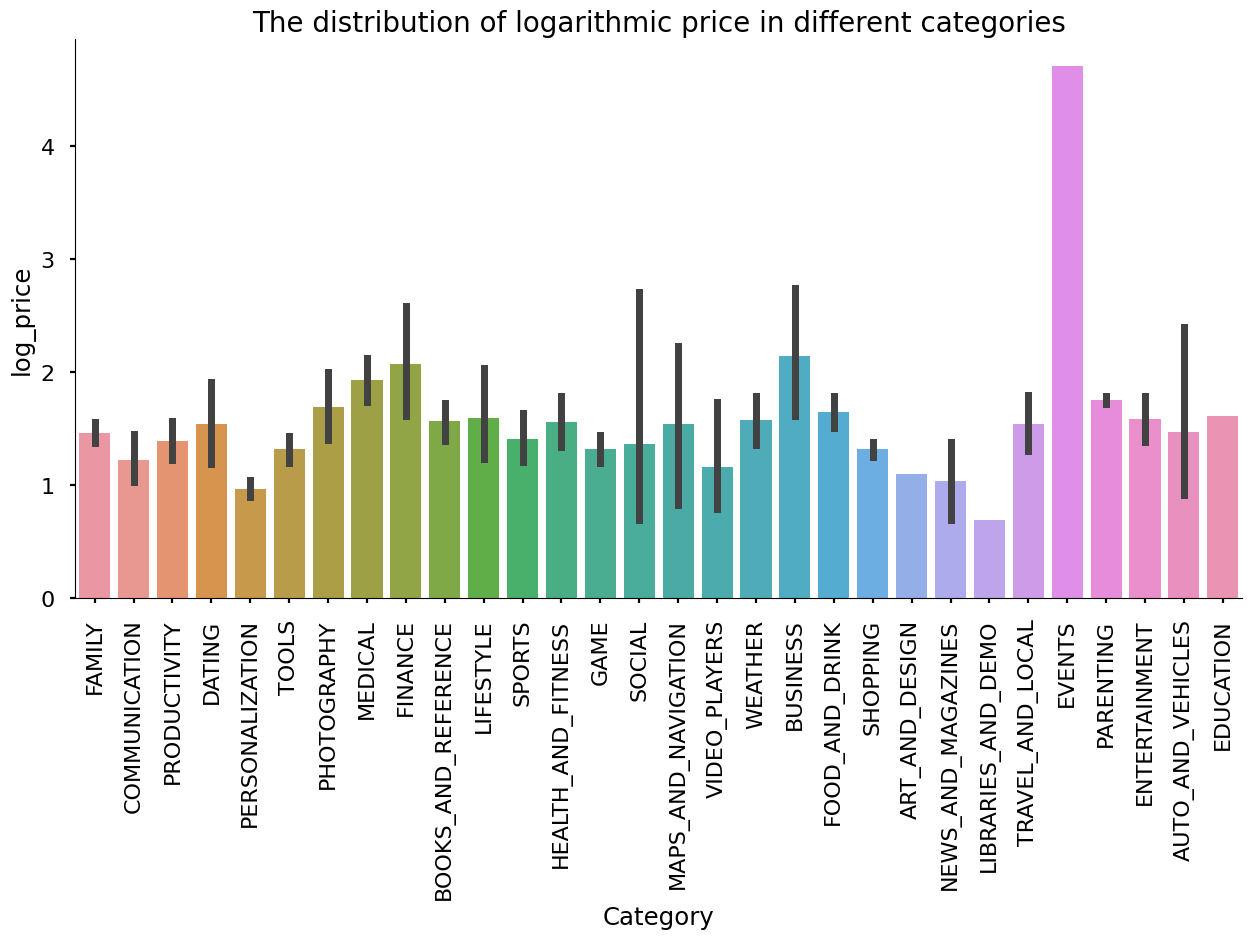

In [457]:
g = sns.catplot(x="Category",y="log_price", data=df_log[(df_log.Type=='Paid') & (df_log.log_price < 5)], kind='bar')
g.fig.set_figheight(7)
g.fig.set_figwidth(20)
plt.title('The distribution of logarithmic price in different categories', size = 20)
plt.xticks(rotation=90)
plt.show()

The Lifestyle and Finance categories became more realistic and stable. So, we are removing extra expensive samples.

In [458]:
df = df[~((df_log.Category.isin(['LIFESTYLE', 'FINANCE'])) & (df_log.log_price > 5))]
df_log = df_log[~((df_log.Category.isin(['LIFESTYLE', 'FINANCE'])) & (df_log.log_price > 5))]

<a id='Категории_и_размер'></a>
### 2.7. Category and Size

Let's add the logarithm of size to df_log.

In [459]:
df_log['log_size'] = df_log.Size.apply(np.log1p)

**Task 14** Explore the distribution of app size in each category. Use the df_log table and the log_size column

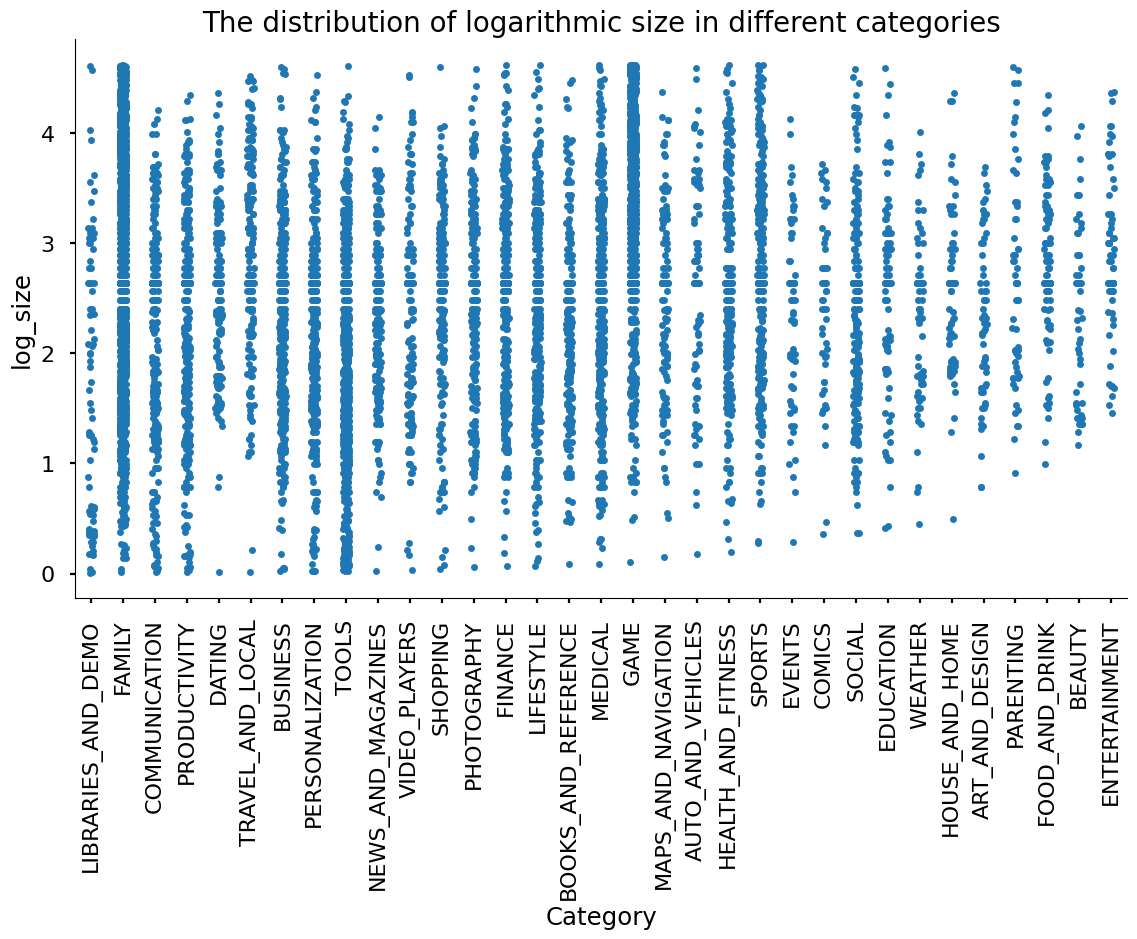

In [460]:
### BEGIN SOLUTION
g = sns.catplot(x="Category", y="log_size", data=df_log)
### END SOLUTION
# g = sns.catplot(x= ?, y= ?, data=df_log)

g.fig.set_figheight(7)
g.fig.set_figwidth(20)
plt.title('The distribution of logarithmic size in different categories', size = 20)
plt.xticks(rotation=90)
plt.show()

<a id='3_feature_space'></a>
## 3. Feature Engineering

Let's create a table where we will store the results.

In [461]:
results = pd.DataFrame(columns=['method', 'model', 'val score', 'test score', 'learning time', 'predict time'])

To measure processing time we will use a special context manager.

In [462]:
class Timer(object):
    def __init__(self):
        self.elapsed_time = 0
    def __enter__(self):
        self.start = time()
    def __exit__(self, type, value, traceback):
        self.end = time()
        self.elapsed_time = int((self.end - self.start)*1000)

timer = Timer()

In [463]:
# # Store solutions of previous exercise
# df.to_parquet('data/feature_engineering_ex2.parquet')

# Load data from previous exercise
df = pd.read_parquet('data/feature_engineering_ex2.parquet')

<a id='base_model'></a>
### 3.1. Base model

Our task is to determine the rating of the application. Let's take this column into a separate variable, and remove it from the main dataset.

In [464]:
Y = df.Rating.astype(int)
df = df.drop(columns=['Rating'])

The so-called *majority classifier* can be the simplest type of a base model. The point is: we always predict the class that is most common in our training dataset.

Let's split the data into training and test sets. For appropriate comparision of the different models, this partition must always be the same, that's why we use fixed *random_state*. For now, we don't need the features, only the target variable.

We remind you that the train/test split of dataset samples should actually be performed before data processing!!!

In [465]:
y_train, y_test = train_test_split(Y,  test_size=0.3, random_state=42)

Now let's determine which class is most common in the training data.

In [466]:
classes, counts = np.unique(y_train, return_counts=True)
major_class = classes[np.argmax(counts)]
major_class

2

In the training set, samples with second class are more common. Then our test prediction will be an array with the same size as the size of out test set and it will be completely filled with 2. 

In [467]:
base_predict = np.full(y_test.shape, major_class)

To analyze the results, we will use a function that displays several different metrics.

In [468]:
def calculate_metrics(y_predict, y_test):
    print('acсuracy: {:.4f}'.format(accuracy_score(y_test, y_predict)))
    print('F1 score: {:.4f}'.format(f1_score(y_test, y_predict, average='macro')))
    print(classification_report(y_test, y_predict))
    print(confusion_matrix(y_test, y_predict))

Now let's calculate the accuracy of the majority classifier.

In [469]:
calculate_metrics(base_predict, y_test)

acсuracy: 0.3437
F1 score: 0.1705
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       977
           1       0.00      0.00      0.00       921
           2       0.34      1.00      0.51       994

    accuracy                           0.34      2892
   macro avg       0.11      0.33      0.17      2892
weighted avg       0.12      0.34      0.18      2892

[[  0   0 977]
 [  0   0 921]
 [  0   0 994]]


These will be our reference values. Let's write them in the table.

In [470]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method':'Baseline',
                'model': 'Majority',
                'val score': None,
                'test score': f1_score(base_predict, y_test, average='macro'), 
                'learning time' : None,
                'predict time': None
            },
            index=[len(results)]
        ),
    ],
    ignore_index=True
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,None,0.170527,None,None


<a id='origin_features'></a>
### 3.2. Basic features

Now we are going to use the original feature space to predict the target variable and measure the accuracy of the prediction. We will use only numeric and boolean features: they don't require the preparation, unlike text.

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9639 entries, 1532 to 1565
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   App                 9639 non-null   object 
 1   Category            9639 non-null   object 
 2   Size                9639 non-null   float64
 3   Type                9639 non-null   object 
 4   Price               9639 non-null   float64
 5   Content Rating      9639 non-null   object 
 6   Android Ver         9639 non-null   object 
 7   unknown_size        9639 non-null   bool   
 8   is_cat_equal_genre  9639 non-null   bool   
dtypes: bool(2), float64(2), object(5)
memory usage: 621.3+ KB


In [472]:
numeric_df = df.select_dtypes(include=['int64', 'float64', 'bool'])
numeric_df.head()

,Size,Price,unknown_size,is_cat_equal_genre
1532,0.008301,0.00,False,True
1553,0.010742,0.00,False,True
4983,0.013672,0.99,False,False
10072,0.016602,3.99,False,True
4977,0.016602,1.29,False,True


Now we'll get our test and training sets. (notice that we use the same random_state and therefore the data is split the same way as before)

In [473]:
X_train, X_test, y_train, y_test = train_test_split(numeric_df, Y, 
                                                    test_size=0.3, 
                                                    random_state=42)

We will train a Logistic Regression model - one of the simplest ones among linear classifiers. To perform hyperparameter optimization we'll use cross-validation by applying Pipeline and GridSearchCV functions. This specific classifier was chosen in order to decrease the training time within the workshop. Results for more complex models will be provided in the bonus file.

> **Data scaling** — the process of adjusting the data to a single scale. The main methods are **normalization** - adjusting all features to a value in the range from 0 to 1, and **standardization** - data preprocessing, after which each feature has an average of 0 and a variance of 1

Scaling the data can significantly affect the process of training a model. For example, it increases the speed and the stability of gradient descent algorithm. Moreover, methods that rely on working in a multidimensional space (such as KNN) will not work correctly if the features have a different scale. These effects don't always appear, but scaling the data is unlikely to make the results worse, so you should always perform it before training the model.

Now let's create a pipeline and set a grid of the hyperparameters for the classifier.

Note: if the Logistic Regression algorithm does not converge because the of the parameters selected it will throw warnings.

In [474]:
pipe = Pipeline([('scale', StandardScaler()),
                 ('clf', LogisticRegression(random_state=42))])

params = {
    'clf__C': [0.01, 0.05, 0.1, 0.5, 0.9, 0.99],
    'clf__penalty': ['l1', 'l2', 'elasticnet']
} 

In [475]:
np.random.seed(123)

clf = GridSearchCV(pipe, 
                   cv=3,  
                   param_grid=params, 
                   scoring='f1_macro',
                   verbose=1,
                   n_jobs=6)

with timer:
    clf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [476]:
learning_time = timer.elapsed_time

In [477]:
best_clf = clf.best_estimator_.steps[1][1]
best_clf

LogisticRegression(C=0.99, random_state=42)

In [478]:
clf.best_score_

0.4469788214651802

In [479]:
with timer:
    predict = clf.predict(X_test)
    
predict_time = timer.elapsed_time

In [480]:
calculate_metrics(predict, y_test)

acсuracy: 0.4879
F1 score: 0.4505
              precision    recall  f1-score   support

           0       0.46      0.70      0.55       977
           1       0.35      0.15      0.21       921
           2       0.59      0.60      0.59       994

    accuracy                           0.49      2892
   macro avg       0.47      0.48      0.45      2892
weighted avg       0.47      0.49      0.46      2892

[[682 137 158]
 [526 136 259]
 [289 112 593]]


Again, we shall save the results in the table.

In [481]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method':'Numeric',
                'model': 'LR',
                'val score': clf.best_score_,
                'test score': f1_score(clf.predict(X_test), y_test, average='macro'), 
                'learning time': learning_time,
                'predict time': predict_time,
            },
            index=[len(results)]
        ),
    ],
    ignore_index=True
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3


As you can see, the F1-score of the model is slightly higher than the score of the majority classifier.

As the next step we should add categorical features. First we will encode them features into numerical ones. This can be done in multiple ways.

For example, you could take one column, index all unique category names with numbers and just replace them in the column. This type of encoding is called Label Encoding. This method is usually bad because most of the time the values of numbers don't reflect the category relation. For example, encoding the application with type GAME as 1 and with MEDICAL as 2 turns out that MEDICAL > GAME, while such a comparison is incorrect. Therefore, many methods, especially linear ones, will not work well with this type of encoding. At the same time, methods based on decision trees will work fine.

Another popular type of encoding is called Dummy Encoding or One-hot Encoding. Each unique category name has its own column. The values in this column can only be 0 and 1. If the sample instance has some category, then the corresponding dummy-column will contain a "1" value, and all others will be filled with zeros. This type of encoding has the disadvantage that if there are a lot of unique categories, the size of the feature matrix becomes too large and sparse. Therefore additional preprocessing of categorical data may be necessary.

There are other, less popular and well known techniques, but here we will stick to One-hot encoding.

First of all, we need to copy all the data to the new dataset.

In [482]:
df_dummies = df.copy()

Next, it is necessary to delete the application names - they are unique for each sample. If we encode them with dummy encoding, it will lead to adding N, where N is the length of the whole dataset, and all these columns will have only one value 1 and all the others 0. Such features obviously do not work.

In [483]:
df_dummies = df_dummies.drop(columns=['App'])

As was said before, sometimes it makes sense to encode columns with LabelEncoding. In our case the Content Rating column is suitable for this approach. We should encode it in a way, so with the growth of restrictions, the corresponding number will also grow.

In [484]:
con_rat_dict =  {'Everyone':0, 'Everyone 10+':1, 'Teen':2, 'Mature 17+':3}
df_dummies = df_dummies.replace({"Content Rating": con_rat_dict})

Now let's encode the remaining categories with the dummy method. 

In [485]:
df_dummies = pd.get_dummies(df_dummies)

df_dummies.shape

(9639, 44)

Now we have 44 features instead of 4.  
Let's prepare a training and test set. 

In [486]:
X_train, X_test, y_train, y_test = train_test_split(df_dummies, Y,
                                                    test_size=0.3, 
                                                    random_state=42)

**Task 15** Train the model, make a prediction on the test data and output the statistics. Don't forget to measure your training time.

In [487]:
np.random.seed(123)

with timer:
### BEGIN SOLUTION
    clf = GridSearchCV(pipe, cv=3,  
                       param_grid=params, 
                       scoring='f1_macro', verbose=1,
                       n_jobs=6).fit(X_train, y_train)
### END SOLUTION
    # clf = GridSearchCV(pipe, cv=3,  
                       # param_grid=params, 
                       # scoring='f1_macro', verbose=1,
                       # n_jobs=6).fit(?, ?)
    
learning_time = timer.elapsed_time

Fitting 3 folds for each of 18 candidates, totalling 54 fits


In [488]:
print('Best score:', clf.best_score_)

Best score: 0.5313957040483775


In [489]:
with timer:
    predict = clf.predict(X_test)
    
predict_time = timer.elapsed_time

In [490]:
calculate_metrics(predict, y_test)

acсuracy: 0.5322
F1 score: 0.5210
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       977
           1       0.41      0.33      0.36       921
           2       0.61      0.64      0.63       994

    accuracy                           0.53      2892
   macro avg       0.52      0.53      0.52      2892
weighted avg       0.52      0.53      0.52      2892

[[601 234 142]
 [363 300 258]
 [167 189 638]]


In [491]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method': 'Categories',
                'model': 'LR',
                'val score': clf.best_score_,
                'test score': f1_score(clf.predict(X_test), y_test, average='macro'), 
                'learning time': learning_time,
                'predict time': predict_time,
            },
            index=[len(results)]
        ),
    ],
    ignore_index=True,
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3
2,Categories,LR,0.531396,0.521042,724,6


As you can see, adding categorical features have improved the accuracy of the model.

<a id='feature_generation'></a>
### 3.3. Feature generation

Now we will expand our feature space by adding new features - manually crafted with love and care! 

First we need a separate copy of the original dataset.

In [492]:
df_new = df.copy()

Let's add a price per megabyte column.

In [493]:
df_new['price_for_mb'] = df_new.Size/df_new.Price
df_new['price_for_mb'] = df_new['price_for_mb'].replace([np.inf, -np.inf], 0)

Also let's add logarithms for price and size.

In [494]:
df_new['log_price'] = df_new.Price.apply(np.log1p)
df_new['log_size'] = df_new.Size.apply(np.log1p)

Usually it is useful to indroduce polynomial features for the numerical ones. Let's make them from the previously calculated logarithms of price and size. To do this, we can use the scikit-learn function Polynomial Features.

In [495]:
p = PolynomialFeatures(degree=2).fit(df_new[['log_price', 'log_size']])
poly_df = pd.DataFrame(p.transform(df_new[['log_price', 'log_size']]), 
                        columns=p.get_feature_names_out(input_features=['log_price', 'log_size']))
poly_df.head(10)

,1,log_price,log_size,log_price^2,log_price log_size,log_size^2
0,1.0,0.000000,0.008267,0.000000,0.000000,0.000068
1,1.0,0.000000,0.010685,0.000000,0.000000,0.000114
2,1.0,0.688135,0.013579,0.473529,0.009344,0.000184
3,1.0,1.607436,0.016465,2.583850,0.026467,0.000271
4,1.0,0.828552,0.016465,0.686498,0.013642,0.000271
5,1.0,1.383791,0.017425,1.914878,0.024113,0.000304
6,1.0,0.000000,0.017425,0.000000,0.000000,0.000304
7,1.0,0.000000,0.019343,0.000000,0.000000,0.000374
8,1.0,0.000000,0.022212,0.000000,0.000000,0.000493
9,1.0,1.607436,0.023167,2.583850,0.037240,0.000537


You can see that there are new columns low_price^2, log_price, log_size and log_size^2. Now you need to attach them to the main dataset, and discard unnecessary ones. To avoid errors during concatenation, we will replace the poly_df index with the df_new index.

In [496]:
poly_df = poly_df.drop(columns=['log_price', 'log_size', '1'])
poly_df.index = df_new.index
df_new = pd.concat([df_new, poly_df.reindex(df_new.index)], axis=1)

In [497]:
df_new.head(5)

,App,Category,Size,Type,Price,Content Rating,Android Ver,unknown_size,is_cat_equal_genre,price_for_mb,log_price,log_size,log_price^2,log_price log_size,log_size^2
1532,Essential Resources,LIBRARIES_AND_DEMO,0.008301,Free,0.00,Everyone,5 and up,False,True,0.000000,0.000000,0.008267,0.000000,0.000000,0.000068
1553,Market Update Helper,LIBRARIES_AND_DEMO,0.010742,Free,0.00,Everyone,1 and up,False,True,0.000000,0.000000,0.010685,0.000000,0.000000,0.000114
4983,My baby firework (Remove ad),FAMILY,0.013672,Paid,0.99,Everyone,Varies with device,False,False,0.013810,0.688135,0.013579,0.473529,0.009344,0.000184
10072,ExDialer PRO Key,COMMUNICATION,0.016602,Paid,3.99,Everyone,1 and up,False,True,0.004161,1.607436,0.016465,2.583850,0.026467,0.000271
4977,Ad Remove Plugin for App2SD,PRODUCTIVITY,0.016602,Paid,1.29,Everyone,1 and up,False,True,0.012869,0.828552,0.016465,0.686498,0.013642,0.000271


Add the number of characters and the number of words in the title as features.

In [498]:
df_new['len_of_app_title'] = df_new.App.apply(len)
df_new['count_of_app_title'] = df_new.App.str.split(' ').apply(len)

The names of applications contain a lot of garbage. It is better to clean it. 

In [499]:
# Let's change to lower case, remove special characters, leave only Latin letters and numbers.
df_new['cleantext'] = df_new.App.str.lower()
df_new['cleantext'] = df_new.cleantext.str.replace('[-_]', ' ', regex=True)
df_new['cleantext'] = df_new.cleantext.str.replace('[^0-9A-Za-z ]+', '', regex=True)

First we need to check what the text looks like after cleaning.

In [500]:
df_new[['App', 'cleantext']].head(10)

,App,cleantext
1532,Essential Resources,essential resources
1553,Market Update Helper,market update helper
4983,My baby firework (Remove ad),my baby firework remove ad
10072,ExDialer PRO Key,exdialer pro key
4977,Ad Remove Plugin for App2SD,ad remove plugin for app2sd
479,"Private Dating, Hide App- Blue for PrivacyHider",private dating hide app blue for privacyhider
9781,Fill 'er Up,fill er up
8022,Morse Code Reader,morse code reader
209,Plugin:AOT v5.0,pluginaot v50
9586,EM Launcher Pro,em launcher pro


Now, after filtering, we can add the number of characters and the number of words as features.

In [501]:
df_new['len_of_cleantext_title'] = df_new.cleantext.apply(len)
df_new['count_of_cleantext_title'] = df_new.cleantext.str.split(' ').apply(len)

Next step is to add the difference between the original number of words and symbols and the normalized ones.

In [502]:
df_new['diff_len_title'] = df_new['len_of_app_title'] - df_new['len_of_cleantext_title']
df_new['diff_count_title'] = df_new['count_of_app_title'] - df_new['count_of_cleantext_title']

In [503]:
df_new[['diff_len_title', 'diff_count_title']].describe()

,diff_len_title,diff_count_title
count,9639.000000,9639.000000
mean,0.538749,-0.228862
std,1.187246,0.457028
min,0.000000,-5.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,32.000000,0.000000


For some reason there are normalized headers that have more words than original ones. We need to check it.

In [504]:
df_new[['App', 'cleantext']][df_new['diff_count_title'] == -5]

,App,cleantext
4354,M3-X5-X6-M-İ3-İ8 RACİNG 2018,m3 x5 x6 m i3 i8 racing 2018


Everything seems fine.

In [505]:
len_vocab = len(set(' '.join(df_new.cleantext.tolist()).split(' ')))
max_count_of_cleantext_title = round(df_new.count_of_cleantext_title.max(), 0)
print('Number of unique words: {}'.format(len_vocab))
print('Maximum number of words in a title: {}'.format(max_count_of_cleantext_title))

Number of unique words: 8922
Maximum number of words in a title: 29


In [506]:
df_new = df_new.drop(columns=['App', 'cleantext'])

Let's encode categorical features into numerical vectors. 

**Task 16:** Encode categorical features to one-hot format using the [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) function. Don't forget about the special case with Content Rating.

In [507]:
df_new = df_new.replace({"Content Rating": con_rat_dict})

### BEGIN SOLUTION
df_new = pd.get_dummies(df_new)
### END SOLUTION
# df_new = pd. ?

df_new.shape

(9639, 56)

Now it's time to visualize our data. We will use UMAP for this.
It is advisable to standardize the data before using this algorithm.


> **UMAP** (Uniform Manifold Approximation and Projection) - this is a relatively new dimensionality reduction algorithm. Previously the most popular algorithm for these purposes was t-SNE. However UMAP is better in almost every way: UMAP has no restrictions on the dimension of the original feature space, it is much faster and more computationally efficient than t-SNE, and also better in the task of transferring the global data structure to a new, reduced space (as the authors of the algorithm claim). For these reasons t-SNE is hardly used these days.


In [508]:
scaled_data = StandardScaler().fit_transform(df_new)

In [509]:
%%time
np.random.seed(1)
X_umap = umap.UMAP(n_components=2, random_state=2).fit_transform(scaled_data)

CPU times: user 15.9 s, sys: 1.03 s, total: 16.9 s
Wall time: 13.8 s


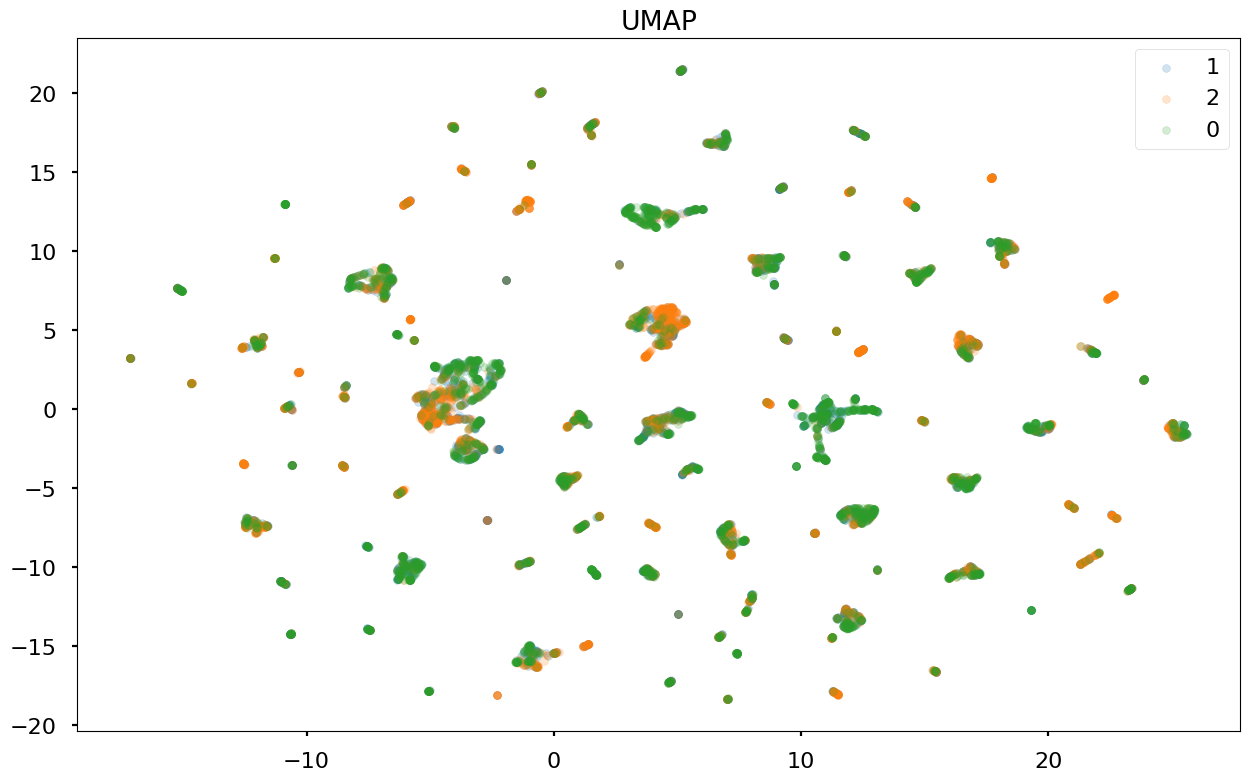

In [510]:
plt.figure(figsize=[15, 9])
plt.title('UMAP')

for i in Y.unique():
    indx = np.where(Y.values == i)
    plt.scatter(X_umap[indx, 0], X_umap[indx, 1], marker='.', alpha=0.2, label=i)
    plt.legend()
plt.show()

You can see that there is a lot of clusters and they contain different proportions of applications with different ratings. Let's apply a clustering algorithm to separate these groups. For now we will assume that we have 30 clusters and use the k_means algorithm. 

In [511]:
cls = cluster.KMeans(n_clusters=30, random_state=42)
kmeans_labels = cls.fit_predict(scaled_data)

# For Google Colab below

# Unfortunately, Google collab doesn't allow to reproduce KMeans model training in spite of the random_state.
# Without it we can't reproduce our clusters and distributions inside them. That's why we're loading pretrained cluster
# model. If you want train your own cluster model you can use the commented code

# m_file = BytesIO(requests.get(CLUSTER_F).content)
# cls = load(m_file)
# kmeans_labels = cls.predict(scaled_data)

Now we visualize the results of our clustering.

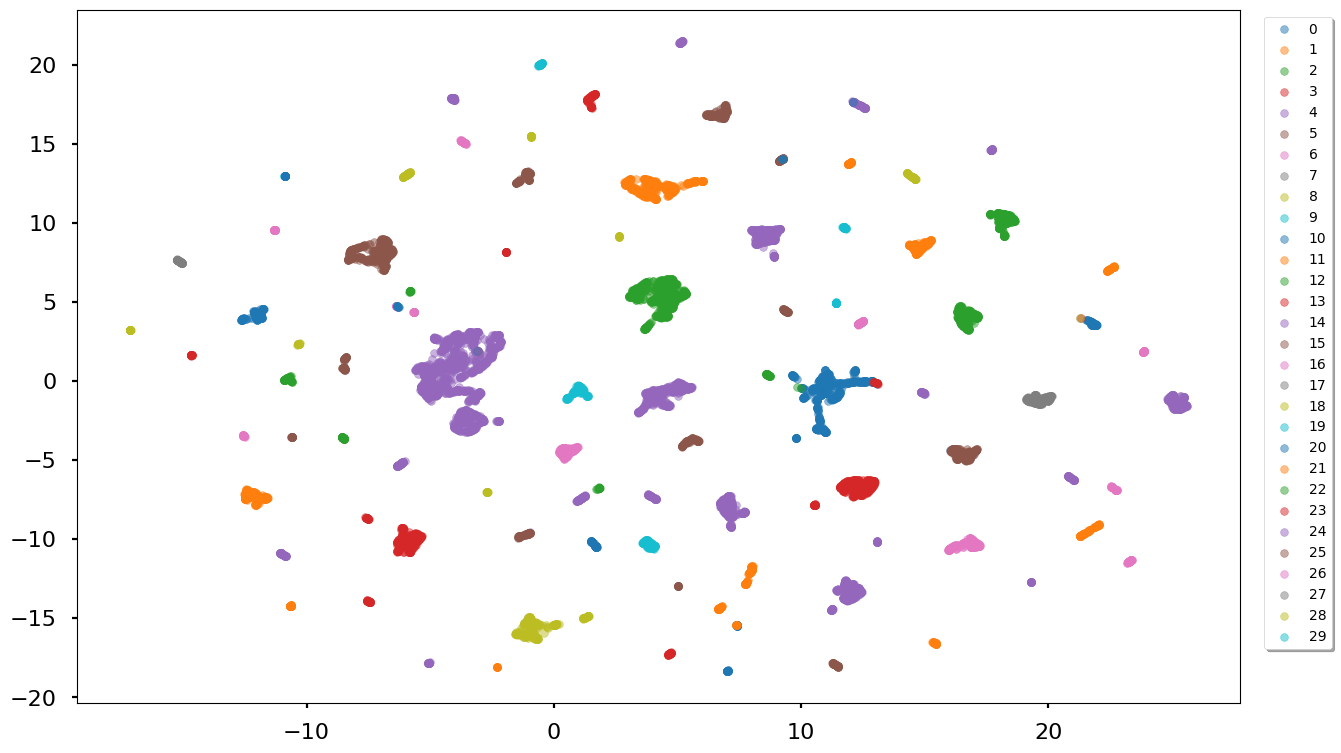

In [512]:
plt.figure(figsize=[15, 9])
ax = plt.subplot()

for i in np.unique(kmeans_labels):
    indx = np.where(kmeans_labels == i)
    plt.scatter(X_umap[indx, 0], X_umap[indx, 1], marker='.', alpha=0.5, label=i)
ax.legend(loc='upper center', bbox_to_anchor=(1.05, 1.0),  ncol=1, fancybox=True, shadow=True, fontsize=10)
plt.show()

Looks promissing. Let's explore whether there is a difference in the distributions of the target variable in each cluster. 

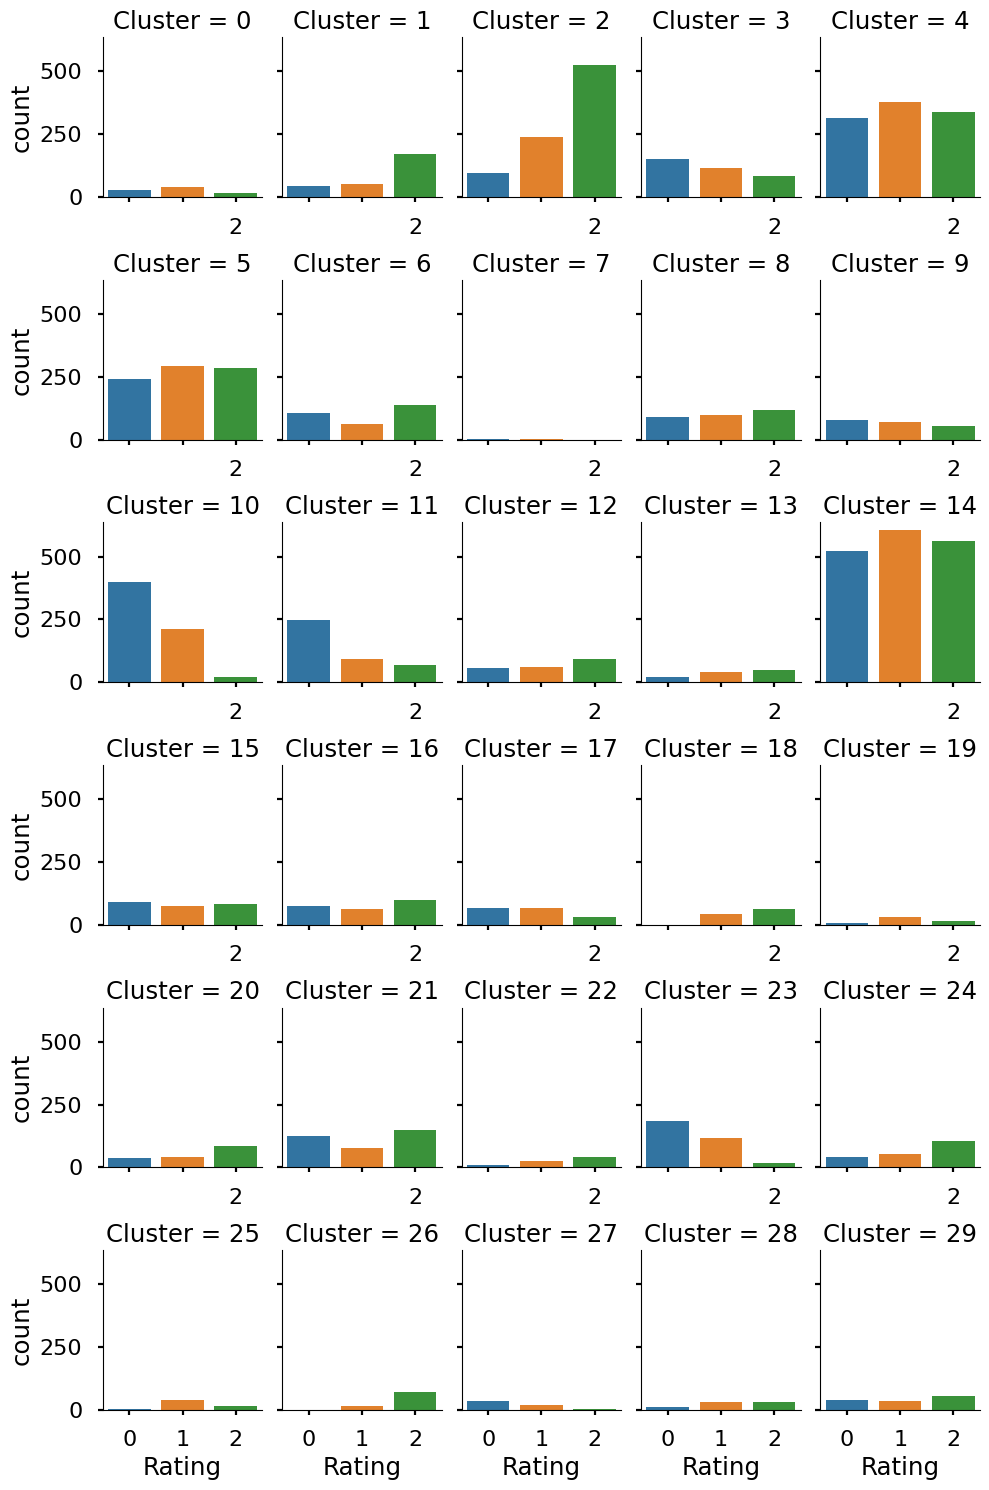

In [513]:
df_clstr = pd.DataFrame({'Cluster': kmeans_labels, 'Rating':Y})
g = sns.catplot(x="Rating", col="Cluster", col_wrap=5, data=df_clstr, kind="count", height=2.5, aspect=.8)

Obviously, the distribution of the target variable differs in many way throughout the clusters. We probably should add the cluster indexes to the main dataset. Note that the cluster index is a category. To perform one-hot encoding we will remove the target variable and then we can add new columns to the main dataset.

In [514]:
df_clstr = df_clstr.drop(columns=['Rating'])
df_clstr['Cluster'] = df_clstr['Cluster'].astype('category')
df_clstr = pd.get_dummies(df_clstr)
df_clstr.index = df_new.index

In [515]:
df_new=pd.concat([df_new, df_clstr], axis=1)
df_new.shape

(9639, 86)

It also would be possible to use aggregation features: for example, average, median, minimum, etc. for each category, age rating or other categorical features. You can apply simple mathematical operations to pairs of numerical features (for example, multiply the size of the application by the price): sometimes they don't make explicit sense, but they might be useful. There are also cases of logical addition of features (there is a category Medicine and an age rating of 18+, for example). To obtain such features, it is convenient to use the *featuretools* library. In general, the number of possible new features is just limited only by your imagination. Unfortunately today we don't have enough time go all crazy with manually creating these feature, so we will limit ourselves to the ones that we have already discussed.

Now let's try see if our work paid off

**Task 17:** Split the dataset and target variable into training and test set, train the model, make a prediction on the test data and output the statistics. Don't forget to measure your training time.

In [516]:
X_train, X_test, y_train, y_test = train_test_split(df_new, Y,
                                                    test_size=0.3, 
                                                    random_state=42)

In [517]:
np.random.seed(123)

### BEGIN SOLUTION
with timer:
    clf = GridSearchCV(pipe, cv=3, 
                       param_grid=params, 
                       scoring='f1_macro', verbose=1,
                       n_jobs=6).fit(X_train, y_train)
### END SOLUTION
# with ?:
#    clf = GridSearchCV( ? ).fit( ? )

learning_time = timer.elapsed_time

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [518]:
print('Best score:', clf.best_score_)

Best score: 0.5492100221437757


In [519]:
print('Best params:', clf.best_params_)

Best params: {'clf__C': 0.1, 'clf__penalty': 'l2'}


In [520]:
with timer:
    predict = clf.predict(X_test)
    
predict_time = timer.elapsed_time

In [521]:
calculate_metrics(predict, y_test)

acсuracy: 0.5650
F1 score: 0.5520
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       977
           1       0.46      0.35      0.40       921
           2       0.62      0.70      0.66       994

    accuracy                           0.57      2892
   macro avg       0.55      0.56      0.55      2892
weighted avg       0.55      0.57      0.56      2892

[[620 209 148]
 [329 319 273]
 [133 166 695]]


In [522]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method': 'Manual features',
                'model': 'LR',
                'val score': clf.best_score_,
                'test score': f1_score(clf.predict(X_test), y_test, average='macro'), 
                'learning time':learning_time,
                'predict time': predict_time,
            },
            index=[len(results)],
        ),
    ],
    ignore_index=True,
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3
2,Categories,LR,0.531396,0.521042,724,6
3,Manual features,LR,0.549210,0.552016,1514,11


Adding the manually created features increased the effectiveness of the model.

<a id='dimensional_reduction'></a>
## 4. Feature Selection and Dimensionality Reduction

Usualy it is useful to know which feature are actually doing the work, so we can drop all others as they can actually cause over-fitting and thus hurt the final score. In our case there are only 89 features, but it can be tens and hundreds of thousands. The goal is to reduce the dimensionality of the feature space and not lose useful information.

There are various ways to reduce the dimension of the data:
>*Statistical methods of dimension reduction*
1. Principal Component Analysis
2. Linear Discriminant Analysis
3. Factor analysis

>*Machine Learning based algorithms
1. T-SNE 
2. UMAP and others.

>*Methods based on feature selection*
1. The significance of the features (determined by the training of some models)
2. Filtering methods (rank features based on statistic functions - e.g. Chi square test, ANOVA)
3. Lasso and Ridge regression
4. Greedy algorithm - step by step adding features (Forward Feature Selection) or Backward Feature Elimination

>Autoencoders should be noted as a method of reducing the dimension of data but will not be covered here. 

We will look at a couple of these methods: Principal Component Analysis and Backward Feature Elimination.

<a id='pca'></a>
### 4.1. Principal Component Analysis

Principal Component Analysis (PCA) - one of the popular ways to reduce data dimensionality with minimum loss of information. The challenge of principal component analysis is to find subspaces of smaller dimension, in orthogonal projection on which the data variation (that is, the standard deviation from the mean value) is maximal.

In simple terms, the method finds the n-th number of new axes, projections on which retain as much variance of the original data as possible. The projections themselves become new features.
 
It should be used carefully, because the feature space is radically changing. The information necessary for the algorithms performance can be lost even with a high retention of information content. Also it is very prone to overfitting.

Since the method is related to variance of features, it is necessary to scale data before using PCA.

In [524]:
# # Store solutions of previous exercise
# df.to_parquet('data/feature_engineering_ex3.parquet')

# Load data from previous exercise
df_new = pd.read_parquet('data/feature_engineering_ex3.parquet')
FEATURE_IMPORTANCE_F= './data/feature_importances_logreg.csv'
BONUS_F = './data/bonus_df_alter.csv'

class Timer(object):
    def __init__(self):
        self.elapsed_time = 0
    def __enter__(self):
        self.start = time()
    def __exit__(self, type, value, traceback):
        self.end = time()
        self.elapsed_time = int((self.end - self.start)*1000)

timer = Timer()

def calculate_metrics(y_predict, y_test):
    print('acсuracy: {:.4f}'.format(accuracy_score(y_predict, y_test)))
    print('F1 score: {:.4f}'.format(f1_score(y_predict, y_test, average='macro')))
    print(classification_report(y_predict, y_test))
    print(confusion_matrix(y_predict, y_test))

In [525]:
model = PCA()
pca_data = model.fit_transform(StandardScaler().fit_transform(df_new))

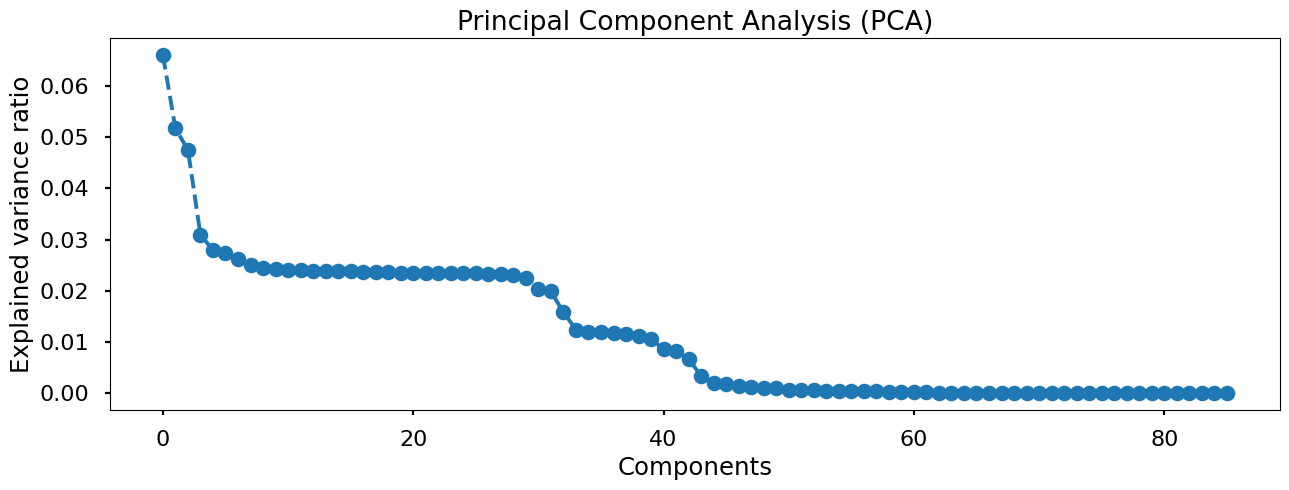

In [526]:
plt.figure(figsize=[13, 5])
plt.title('Principal Component Analysis (PCA)')
plt.plot(range(len(model.explained_variance_ratio_)), model.explained_variance_ratio_, '--o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Components')
plt.tight_layout()
plt.show()

Apparently, most of the information can be saved with 60-70 new projections. Let's see how many components do we need to keep 99% of the original dataset's information.

**Task 18** Apply the PCA method to the *df_new* dataset again, but set the *n_components* parameter to 0.99. If this parameter is an integer, then in the final matrix will be left such a number of features. If it is the float value from 0 to 1, the features will be selected automatically in order to save this amount of information. Print the size of the resulting matrix  

In [527]:
pca_data.shape[1]

86

In [528]:
### BEGIN SOLUTION
model = PCA(n_components=0.99)
pca_data = model.fit_transform(StandardScaler().fit_transform(df_new))
### END SOLUTION
# model = PCA(n_components=?)
# pca_data = model.fit_transform(?)

assert pca_data.shape[1] == 46
pca_data.shape

(9639, 46)

<a id='greedy_selection'></a>
### 4.2. Greedy selection

Now we will use the most reliable, but very resource-intensive method - iterative brute force feature selection. We will remove one feature at a time, predict the target variable and see how the quality metric changes: the more the metric decreases after removing the feature, the more important this feature is. More than that, sometimes the metric might even improve.

This method takes a lot of time. Therefore, we won't calculate it now, but you can see the code and its results below.

In [529]:
# %%time


# X_train, X_test, y_train, y_test = train_test_split(df_new, Y,
#                                                     test_size=0.3,
#                                                     random_state=42)

# scaled_data = StandardScaler().fit_transform(X_train)
# scaled_X = pd.DataFrame(scaled_data, index=X_train.index, columns=X_train.columns)

# clf_logreg = LogisticRegression(random_state=42, C=0.05, penalty='l2')

# parameters_grid = {'C': [0.05]}
# columns = X_train.columns
# important_features = []
# features_scores = []


# np.random.seed(123)


# for j in range(len(columns)-1):
#     print('{}\{}'.format(j, len(columns)))
#     col_for_del = []
#     scores = []
#     for i in columns:
#         cols = columns[columns != i]
#         clf = GridSearchCV(clf_logreg, cv=3,
#                            param_grid=parameters_grid,
#                            scoring='f1_macro',
#                            verbose=0,
#                            n_jobs=6).fit(scaled_X[cols], y_train)

#         scores.append(clf.best_score_)
#     max_col = columns[np.argmax(scores)]
#     print(max_col, clf.best_score_)
#     important_features.append(max_col)
#     features_scores.append(max(scores))
#     columns = columns[columns != max_col]
#     print(j, '\r', end='')
# features_scores.append(0)
# important_features.append(columns[0])

In [530]:
# feature_importances = pd.DataFrame({'features': important_features, 
#                                     'feature_importances': features_scores,
#                                     'iteration': range(len(features_scores))})

In [531]:
# feature_importances = feature_importances.sort_values('iteration', ascending=True)
# feature_importances.to_csv(FEATURE_IMPORTANCE_F, index=False)

In [532]:
feature_importances = pd.read_csv(FEATURE_IMPORTANCE_F)

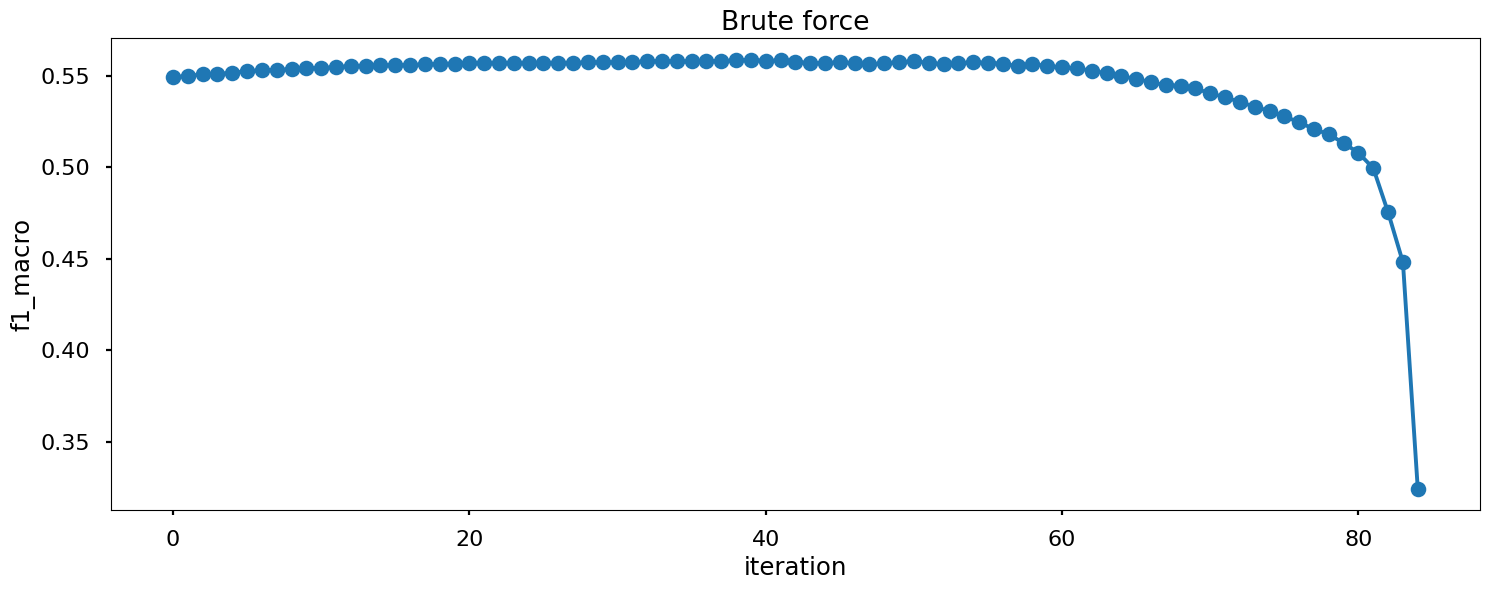

In [533]:
plt.figure(figsize=[15, 6])
plt.title('Brute force')
plt.plot(feature_importances.iteration[:-1], 
         feature_importances.feature_importances[:-1], '-o')
plt.ylabel('f1_macro')
plt.xlabel('iteration')
plt.tight_layout()
plt.show()

Top 20 of the most significant features:

In [534]:
feature_importances.features[::-1][:20]

85            len_of_cleantext_title
84                      unknown_size
83                        log_size^2
82                         Type_Paid
81                  Category_MEDICAL
80                     Category_GAME
79              Android Ver_4 and up
78    Android Ver_Varies with device
77                        Cluster_22
76            Category_ENTERTAINMENT
75                         Cluster_9
74                        Cluster_12
73            Category_COMMUNICATION
72                log_price log_size
71                count_of_app_title
70                        Cluster_26
69                    Content Rating
68                        Cluster_13
67                         Cluster_8
66                Category_PARENTING
Name: features, dtype: object

Let's find at what stage was the best accuracy.

In [535]:
feature_importances[feature_importances.feature_importances == feature_importances.feature_importances.max()]

,features,feature_importances,iteration
39,Cluster_16,0.558666,39


In [536]:
max_id = feature_importances[
    feature_importances.feature_importances == feature_importances.feature_importances.max()
].index[0]

print('We can leave {} features'.format(len(feature_importances)-max_id))

We can leave 47 features


In [537]:
selected_features = feature_importances.features[max_id:]

<a id='4_final_prediction'></a>
### 4.3. Final prediction

**Task 19** Train the model on the features obtained by the greedy selection method and the PCA method. Add the results to the table.

In [538]:
# Greedy features

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(df_new[selected_features], Y,                                                   
                                                    test_size=0.3, 
                                                    random_state=42)
### END SOLUTION
# X_train, X_test, y_train, y_test = train_test_split(df_new[ ? ], Y,                                                   
#                                                     test_size=0.3, 
#                                                     random_state=42)

In [539]:
pipe = Pipeline([('scale', StandardScaler()),
                 ('clf', LogisticRegression(random_state=42))])

params = {
    'clf__C': [0.01, 0.05, 0.1, 0.5, 0.9, 0.99],
    'clf__penalty': ['l1', 'l2', 'elasticnet']
} 

np.random.seed(123)

with timer:
### BEGIN SOLUTION
    clf = GridSearchCV(pipe, cv=3,  
                       param_grid=params, 
                       scoring='f1_macro', verbose=1,
                       n_jobs=6).fit(X_train, y_train)
### END SOLUTION
#     clf = GridSearchCV( ? ).fit( ? )
    
learning_time = timer.elapsed_time

with timer:
    predict = clf.predict(X_test)
    
predict_time = timer.elapsed_time

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [540]:
calculate_metrics(predict, y_test)

acсuracy: 0.5567
F1 score: 0.5446
              precision    recall  f1-score   support

           0       0.63      0.57      0.60      1093
           1       0.34      0.44      0.39       711
           2       0.68      0.62      0.65      1088

    accuracy                           0.56      2892
   macro avg       0.55      0.54      0.54      2892
weighted avg       0.58      0.56      0.57      2892

[[620 331 142]
 [217 316 178]
 [140 274 674]]


In [541]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method': 'Greedy selection',
                'model': 'LR',
                'val score': clf.best_score_,
                'test score': f1_score(clf.predict(X_test), y_test, average='macro'), 
                'learning time': learning_time,
                'predict time': predict_time,
            },
            index=[len(results)],
        ),
    ],
    ignore_index=True,
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3
2,Categories,LR,0.531396,0.521042,724,6
3,Manual features,LR,0.549210,0.552016,1514,11
4,Greedy selection,LR,0.543365,0.544581,764,4


In [542]:
# PCA features

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(df_new, Y, 
                                                    test_size=0.3, 
                                                    random_state=42)
### END SOLUTION
# X_train, X_test, y_train, y_test = train_test_split( ? )

In [543]:
np.random.seed(123)

pipe = Pipeline([('scale', StandardScaler()),
                 ('pca', PCA(n_components=0.99)),
                 ('clf', LogisticRegression(random_state=42))])

### BEGIN SOLUTION
with timer:
    clf = GridSearchCV(pipe, cv=3, 
                       param_grid=params, 
                       scoring='f1_macro', verbose=1,
                       n_jobs=6).fit(X_train, y_train)
### END SOLUTION
# with ?
#     clf = ?    

learning_time = timer.elapsed_time

with timer:
    predict = clf.predict(X_test)
    
predict_time = timer.elapsed_time    

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [544]:
calculate_metrics(clf.predict(X_test), y_test)

acсuracy: 0.5581
F1 score: 0.5452
              precision    recall  f1-score   support

           0       0.64      0.57      0.61      1094
           1       0.34      0.44      0.38       708
           2       0.68      0.62      0.65      1090

    accuracy                           0.56      2892
   macro avg       0.55      0.54      0.55      2892
weighted avg       0.58      0.56      0.57      2892

[[628 341 125]
 [207 309 192]
 [142 271 677]]


In [545]:
results = pd.concat(
    [
        results, 
        pd.DataFrame(
            {
                'method': 'PCA features',
                'model': 'LR',
                'val score': clf.best_score_,
                'test score': f1_score(clf.predict(X_test), y_test, average='macro'), 
                'learning time': learning_time,
                'predict time': predict_time,
            },
            index=[len(results)],
        ),
    ],
    ignore_index=True,
)

results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3
2,Categories,LR,0.531396,0.521042,724,6
3,Manual features,LR,0.549210,0.552016,1514,11
4,Greedy selection,LR,0.543365,0.544581,764,4
5,PCA features,LR,0.547312,0.545185,1299,10


<a id='conclusions'></a>
### 4.4. Conclusion

In [546]:
results

,method,model,val score,test score,learning time,predict time
0,Baseline,Majority,NaN,0.170527,None,None
1,Numeric,LR,0.446979,0.450473,2412,3
2,Categories,LR,0.531396,0.521042,724,6
3,Manual features,LR,0.549210,0.552016,1514,11
4,Greedy selection,LR,0.543365,0.544581,764,4
5,PCA features,LR,0.547312,0.545185,1299,10


The best result on the validation set was shown by a model trained on the features obtained by the greedy selection method. Because some features can decrease the accuracy, removing them allows you to get a better result than on the original dataset. However, on the test set, the greedy algorithm showed slightly worse results than the full dataset. This could happen due to the fact that the optimal set of features was selected for the validation set which in our case might have a slightly different distribution and the dataset isn't particularly large. 

The model trained on the features obtained with the PCA method provides an accuracy comparable to the results provided by the models trained on the raw data, but at the same time it learns much faster and the difference between val and test scores is negligible.

We can't say that some approach is definitely better than others, it depends on the task. In some cases, greedy selection can significantly improve the result, but the time it takes can be extremely long and it can overfit. Using the principal component analysis allows you quickly and easily reduce the dimensionality, which can drastically speed up the training and prediction processes, however there may be a loss in accuracy. There are a lot of other algorithms to perform these actions, from this point it's for you to decide which result is more suitable for you.

<a id='bonus'></a>
## 5. Bonus

Below you can find an example of comparative training of different models on different sets of features with a wide random selection of hyperparameters. Training takes a lot of time, so we have commented the code. You can load and view the results at the very end of the script. These results were obtained on a slightly different set of features, so they may differ from the results obtained in the workshop.

In [547]:
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.linear_model import LogisticRegression
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

# log_params = {'clf__C': uniform(0.01, 0.99),
#               'clf__penalty': ['l1', 'l2']} 

# rf_params = {'clf__n_estimators': randint(100, 1000),
#              'clf__max_depth': randint(1,10),
#              'clf__min_samples_leaf': randint(1, 10),
#              'clf__min_samples_split': randint(2, 11)} 

# gb_params = {'clf__learning_rate': uniform(0.01, 0.49),
#              'clf__n_estimators': randint(100, 700),
#              'clf__max_depth': randint(1, 10),
#              'clf__subsample': uniform(0.6, 0.4)}   

# models_dict = {'Logistic Regression':[log_params, LogisticRegression(random_state=42)],
#                'Random Forest':[rf_params, RandomForestClassifier(random_state=42)],
#                'Gradient Boosting': [gb_params, GradientBoostingClassifier(random_state=42)],
#                'XGB':[gb_params, xgb.XGBClassifier(random_state=42)],
#                'CatBoost':[gb_params, CatBoostClassifier(bootstrap_type='Bernoulli', random_state=42, verbose=0)],
#                'LightBoost':[gb_params, LGBMClassifier(random_state=42)]}

# ext_results = pd.DataFrame(columns=['method', 'model', 'val score', 'test score', 'learning time', 'predict time'])

In [548]:
# def custom_pipe(clf, pca='False'):
#     if pca:
#         return  Pipeline([('clf', clf)])
#     else:
#         return Pipeline([('scale', StandardScaler()),
#                          ('clf', clf)])

In [549]:
# X_train_gs, X_test_gs = train_test_split(df_new[selected_features],test_size=0.3, random_state=42)
# X_train_all, X_test_all = train_test_split(df_new,test_size=0.3, random_state=42)

# pca_model = PCA(n_components=0.99)
# scaler = StandardScaler()
# X_train_pca = pca_model.fit_transform(scaler.fit_transform(X_train_all))
# X_test_pca = pca_model.transform(scaler.transform(X_test_all))

# data_dict = {'Manual features':(X_train_all, X_test_all),  
#              'Greedy selection':(X_train_gs, X_test_gs),
#              'PCA':(X_train_pca, X_test_pca)}

In [550]:
# np.random.seed(123)
# for method, (X_train, X_test) in data_dict.items():
#     print(f'Method: {method}\n')
    
#     if method == "PCA":
#         pca_flag = True
#     else:
#         pca_flag = False
    
#     for clf_name, vals in models_dict.items():
#         print(clf_name, '\n')

#         pipe = custom_pipe(vals[1], pca_flag)
        
#         with timer:
#             clf = RandomizedSearchCV(pipe, cv=3, random_state=123, 
#                                      param_distributions=vals[0], 
#                                      n_jobs=4,
#                                      verbose=1,
#                                      n_iter=100,
#                                      scoring='f1_macro').fit(X_train, y_train)

#         print(clf.best_params_ , '\n')

#         learning_time = int(timer.elapsed_time / 300)

#         with timer:
#             predict = clf.predict(X_test)

#         predict_time = timer.elapsed_time

#         ext_results = ext_results.append({'method': method,
#                                           'model': clf_name,
#                                           'val score': clf.best_score_,
#                                           'test score': f1_score(predict, y_test, average='macro'), 
#                                           'learning time': learning_time,
#                                           'predict time': predict_time},
#                                           ignore_index=True)

In [551]:
# ext_results.to_csv(BONUS_F, index=False)

In [552]:
ext_results = pd.read_csv(BONUS_F)

In [553]:
ext_results

,method,model,val score,test score,learning time,predict time
0,Manual features,Logistic Regression,0.544700,0.529029,579,47
1,Manual features,Random Forest,0.553850,0.558358,417,168
2,Manual features,Gradient Boosting,0.577935,0.565543,7908,59
3,Manual features,XGB,0.575011,0.569521,9180,94
4,Manual features,CatBoost,0.578561,0.574374,10389,78
5,Manual features,LightBoost,0.570383,0.565469,997,163
6,Greedy selection,Logistic Regression,0.539769,0.516291,106,11
7,Greedy selection,Random Forest,0.560096,0.551871,362,164
8,Greedy selection,Gradient Boosting,0.576689,0.580544,3789,54
9,Greedy selection,XGB,0.575248,0.569501,3701,120


Training was carried out with a wide choice of parameters. The best result on the validation set was shown by CatBoost on all the features. It also showed the best result on the test set, but on the features obtained with greedy selection. In general, models based on gradient boosting show a similar results. Random Forest is a little behind them. Logistic Regression gives the weakest results.


The accuracy of the models trained on the features obtained with the PCA is lower than in other cases. This is especially evident in the test sample. At the same time, training on them wasn't faster than on other methods, and sometimes even more. 

The comparison of learning time of gradient boosting models with RandomizedSearchCV is not absolutely accurate, as it depends on the *n_estimators* hyperparameter and it is different for each case. 

But in general, it can be noted that CatBoost is trained much longer than other gradient methods. However, it predicts very fast. LightBoost is the fastest learning gradient boosting model. In general, the fastest model in learning and prediction is a logistic regression. So if time is more valuable than accuracy, linear methods are the best choice. If you still want a sufficient accuracy, you should use LightBoost